# Initial analysis of the gut uLIPSTIC dataset: looking at entire dataset

In [1]:
from helper_functions import *
from itertools import permutations
from pandas.api.types import CategoricalDtype
from plotnine import * 
from scipy.cluster.hierarchy import dendrogram, linkage, set_link_color_palette
from scipy.stats import gmean, mannwhitneyu
import anndata as ad
import matplotlib as mpl
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import scanpy as sc
import scirpy as ir
import seaborn as sns

sc.set_figure_params(figsize=(5,4), vector_friendly=False)

/Genomics/grid/users/skwalker/tcr_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
dir_loc = "/Genomics/pritykinlab/share/uLIPSTIC/data/cr_outputs/gut/"

In [3]:
gut_data = sc.read_10x_mtx(dir_loc + "outs/filtered_feature_bc_matrix/", gex_only = False)
gut_data

AnnData object with n_obs × n_vars = 4607 × 32296
    var: 'gene_ids', 'feature_types'

In [4]:
gut_data.var

gene_ids    feature_types
Xkr4                ENSMUSG00000051951  Gene Expression
Gm1992              ENSMUSG00000089699  Gene Expression
Gm19938             ENSMUSG00000102331  Gene Expression
Gm37381             ENSMUSG00000102343  Gene Expression
Rp1                 ENSMUSG00000025900  Gene Expression
...                                ...              ...
C0307                            C0307           Custom
C0308                            C0308           Custom
C0309                            C0309           Custom
C0310                            C0310           Custom
biotin_interaction               C0436           Custom

[32296 rows x 2 columns]

In [5]:
gut_data.var[gut_data.var["feature_types"] == "Custom"].shape

(11, 2)

In [6]:
gut_data.var[gut_data.var["feature_types"] == "Gene Expression"]

gene_ids    feature_types
Xkr4        ENSMUSG00000051951  Gene Expression
Gm1992      ENSMUSG00000089699  Gene Expression
Gm19938     ENSMUSG00000102331  Gene Expression
Gm37381     ENSMUSG00000102343  Gene Expression
Rp1         ENSMUSG00000025900  Gene Expression
...                        ...              ...
AC124606.1  ENSMUSG00000095523  Gene Expression
AC133095.2  ENSMUSG00000095475  Gene Expression
AC133095.1  ENSMUSG00000094855  Gene Expression
AC234645.1  ENSMUSG00000095019  Gene Expression
AC149090.1  ENSMUSG00000095041  Gene Expression

[32285 rows x 2 columns]

## initial QC steps

In [7]:
## initial filtering of cells, genes 
sc.pp.filter_cells(gut_data, min_genes=200)
sc.pp.filter_genes(gut_data, min_cells=5)
gut_data

AnnData object with n_obs × n_vars = 4593 × 16329
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'

In [8]:
gut_data.var['mt'] = gut_data.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(gut_data, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

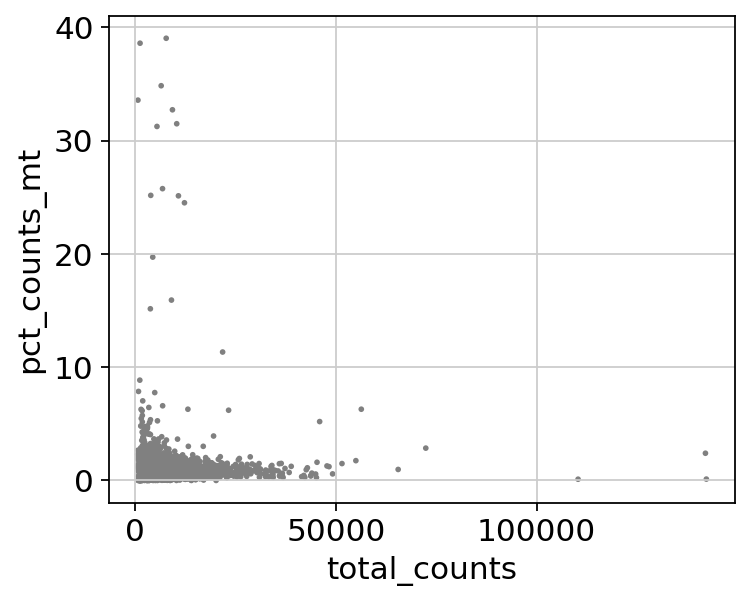

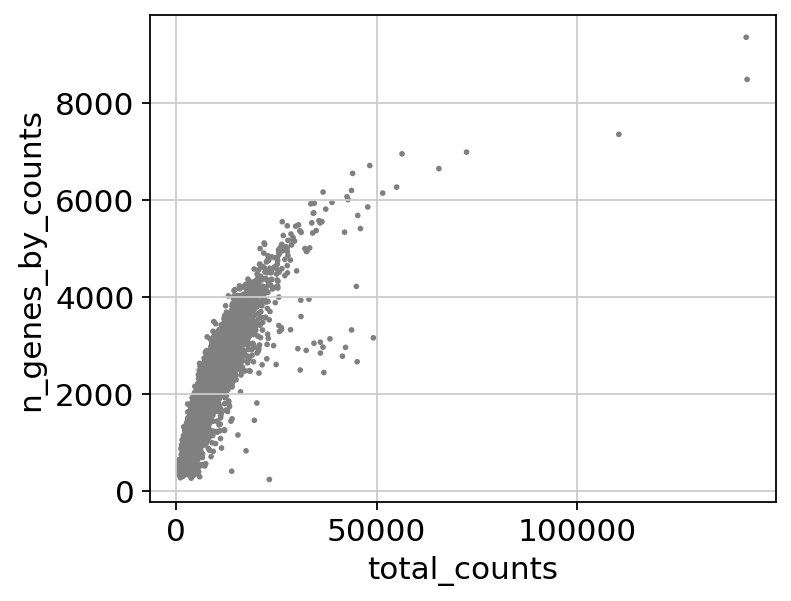

In [9]:
sc.pl.scatter(gut_data, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(gut_data, x='total_counts', y='n_genes_by_counts') 

In [10]:
gut_data = gut_data[(gut_data.obs.pct_counts_mt < 10) & (gut_data.obs.total_counts < 60000), :]
gut_data

View of AnnData object with n_obs × n_vars = 4573 × 16329
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

## remove potential doublets

In [11]:
sc.external.pp.scrublet(gut_data)
gut_data.obs["potential_doublet"] = gut_data.obs["doublet_score"] >= 0.2
np.sum(gut_data.obs["potential_doublet"])

/Genomics/grid/users/skwalker/tcr_env/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.


Automatically set threshold at doublet score = 0.53
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 6.0%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 4.8%


/Genomics/grid/users/skwalker/tcr_env/lib/python3.9/site-packages/scanpy/external/pp/_scrublet.py:271: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


124

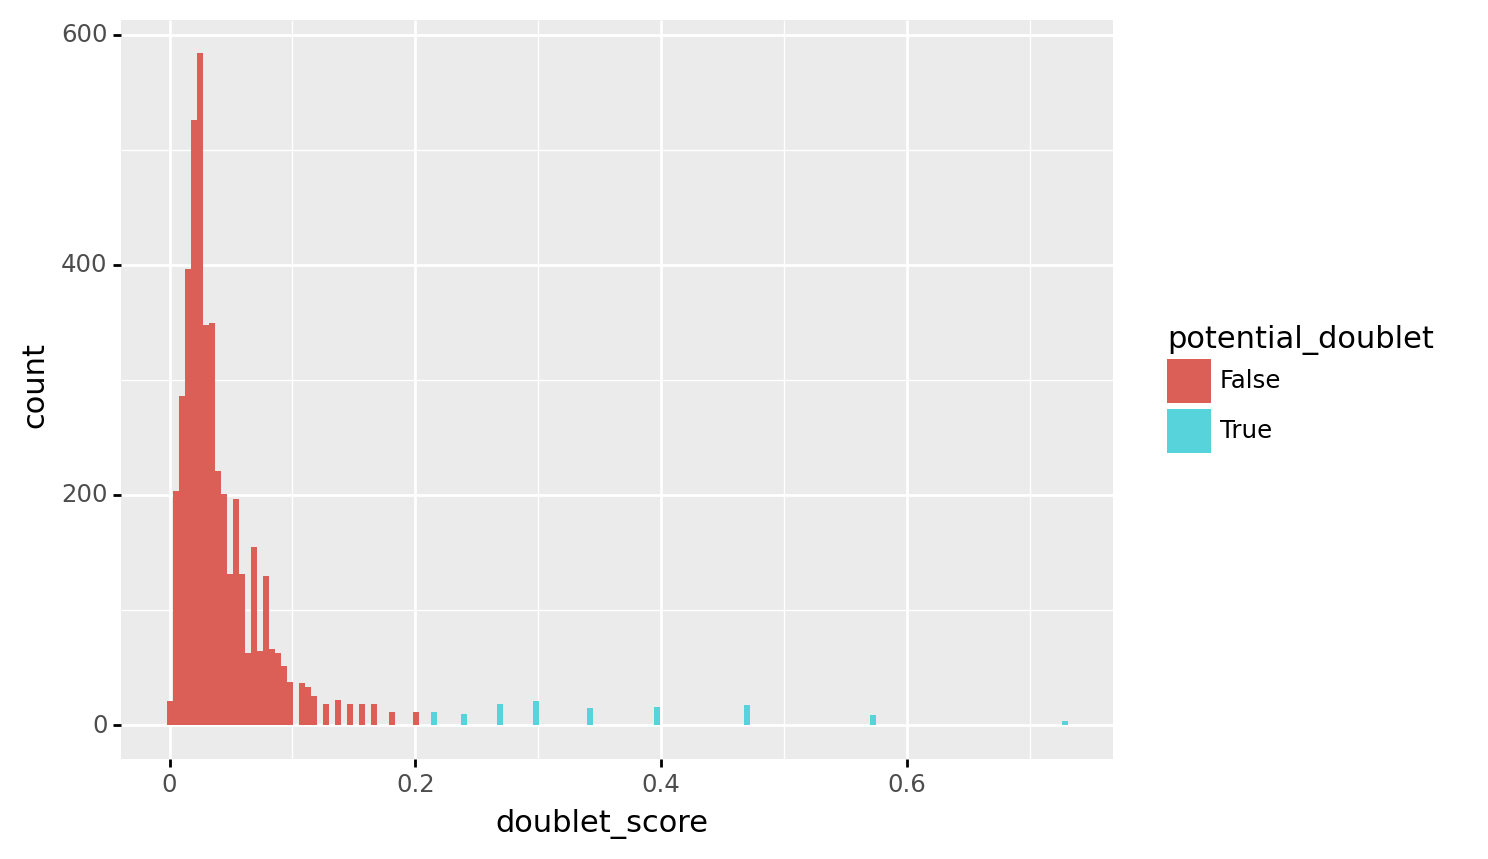

<ggplot: (8744184884246)>

In [12]:
ggplot(gut_data.obs, aes(x="doublet_score", fill="potential_doublet")) + geom_histogram(bins = 150)

In [13]:
gut_data = gut_data[~gut_data.obs["potential_doublet"],:]

## assign cells with correct sample using sample HTO barcode pairs

In [14]:
## C0436 is the biotin HTO, the rest are sample HTOs
gut_data_hash = gut_data[:, (gut_data.var["feature_types"] == "Custom") & (gut_data.var["gene_ids"] != "C0436")]
gut_data_hash

View of AnnData object with n_obs × n_vars = 4449 × 10
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet', 'potential_doublet'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'scrublet'

In [15]:
sample_hto_fractions = pd.DataFrame(gut_data_hash.X.todense()/np.sum(gut_data_hash.X.todense(), axis = 1), 
                                    columns = gut_data_hash.var_names, index = gut_data_hash.obs_names)
sample_hto_fractions.head()

C0301     C0302     C0303     C0304     C0305  \
AAACCTGAGCCAGAAC-1  0.000183  0.000183  0.000550  0.000733  0.000183   
AAACCTGCACTTCGAA-1  0.000000  0.001028  0.001285  0.000000  0.000000   
AAACCTGGTACTTAGC-1  0.000000  0.000000  0.004225  0.005634  0.012676   
AAACCTGGTGTCGCTG-1  0.000000  0.007463  0.002488  0.007463  0.310945   
AAACCTGTCGGCCGAT-1  0.000000  0.002563  0.002050  0.002050  0.295233   

                       C0306     C0307     C0308     C0309     C0310  
AAACCTGAGCCAGAAC-1  0.001100  0.578475  0.418592  0.000000  0.000000  
AAACCTGCACTTCGAA-1  0.001285  0.529049  0.466581  0.000257  0.000514  
AAACCTGGTACTTAGC-1  0.009859  0.573239  0.392958  0.001408  0.000000  
AAACCTGGTGTCGCTG-1  0.641791  0.012438  0.012438  0.002488  0.002488  
AAACCTGTCGGCCGAT-1  0.689390  0.005126  0.001538  0.000513  0.001538

In [16]:
## HTO sample pair names
pair_names = ["IEL 1", "IEL 2", "IEL 3", "IEL 4", "DCs duo 1", "DCs duo 2", 
              "DCs duo 3", "DCs ile 1", "DCs ile 2", "DCs ile 3"]
pairs = [{"C0301", "C0302"}, set(["C0303", "C0304"]), set(["C0305", "C0306"]), set(["C0307", "C0308"]), 
         set(["C0309", "C0310"]), set(["C0301", "C0303"]), set(["C0302", "C0304"]), set(["C0305", "C0308"]),
         set(["C0309", "C0306"]), set(["C0307", "C0310"])]

In [17]:
## returns the two sample HTOs for each cell that make up the highest fraction of sample HTOs for that cell
def get_top_two(cell):
    vals = sample_hto_fractions.columns[np.argsort(sample_hto_fractions.loc[cell])][-2:]
    results = pd.DataFrame({"cell": [cell], "indices": " ".join(vals)})
    if set(vals) in pairs:
        results["name"] = pair_names[np.where(np.array(pairs) == set(vals))[0][0]]
    return results

In [18]:
top_two = pd.DataFrame()
for i in sample_hto_fractions.index:
    top_two = pd.concat([top_two, get_top_two(i)])
top_two.head()

cell      indices   name
0  AAACCTGAGCCAGAAC-1  C0308 C0307  IEL 4
0  AAACCTGCACTTCGAA-1  C0308 C0307  IEL 4
0  AAACCTGGTACTTAGC-1  C0308 C0307  IEL 4
0  AAACCTGGTGTCGCTG-1  C0305 C0306  IEL 3
0  AAACCTGTCGGCCGAT-1  C0305 C0306  IEL 3

In [19]:
top_two[["first", "second"]] = top_two["indices"].str.split(" ", expand = True)
top_two["first_fraction"] = [ sample_hto_fractions.loc[row["cell"]][row["first"]] for _, row in top_two.iterrows()]
top_two["second_fraction"] = [ sample_hto_fractions.loc[row["cell"]][row["second"]] for _, row in top_two.iterrows()]
top_two["second_fraction"] = [ sample_hto_fractions.loc[row["cell"]][row["second"]] for _, row in top_two.iterrows()]
top_two.head()

cell      indices   name  first second  first_fraction  \
0  AAACCTGAGCCAGAAC-1  C0308 C0307  IEL 4  C0308  C0307        0.418592   
0  AAACCTGCACTTCGAA-1  C0308 C0307  IEL 4  C0308  C0307        0.466581   
0  AAACCTGGTACTTAGC-1  C0308 C0307  IEL 4  C0308  C0307        0.392958   
0  AAACCTGGTGTCGCTG-1  C0305 C0306  IEL 3  C0305  C0306        0.310945   
0  AAACCTGTCGGCCGAT-1  C0305 C0306  IEL 3  C0305  C0306        0.295233   

   second_fraction  
0         0.578475  
0         0.529049  
0         0.573239  
0         0.641791  
0         0.689390

In [20]:
## total counts per HTO for each cell
gut_data_hash_df = pd.DataFrame(gut_data_hash.X.todense(), index=gut_data_hash.obs_names, 
                                columns = gut_data_hash.var_names)
gut_data_hash_df.head()

C0301  C0302  C0303  C0304  C0305   C0306   C0307   C0308  \
AAACCTGAGCCAGAAC-1    1.0    1.0    3.0    4.0    1.0     6.0  3155.0  2283.0   
AAACCTGCACTTCGAA-1    0.0    4.0    5.0    0.0    0.0     5.0  2058.0  1815.0   
AAACCTGGTACTTAGC-1    0.0    0.0    3.0    4.0    9.0     7.0   407.0   279.0   
AAACCTGGTGTCGCTG-1    0.0    3.0    1.0    3.0  125.0   258.0     5.0     5.0   
AAACCTGTCGGCCGAT-1    0.0    5.0    4.0    4.0  576.0  1345.0    10.0     3.0   

                    C0309  C0310  
AAACCTGAGCCAGAAC-1    0.0    0.0  
AAACCTGCACTTCGAA-1    1.0    2.0  
AAACCTGGTACTTAGC-1    1.0    0.0  
AAACCTGGTGTCGCTG-1    1.0    1.0  
AAACCTGTCGGCCGAT-1    1.0    3.0

In [21]:
top_two["second_count"] = [ gut_data_hash_df.loc[row["cell"]][row["second"]] for _, row in top_two.iterrows()]
top_two["first_count"] = [ gut_data_hash_df.loc[row["cell"]][row["first"]] for _, row in top_two.iterrows()]
top_two.head()

cell      indices   name  first second  first_fraction  \
0  AAACCTGAGCCAGAAC-1  C0308 C0307  IEL 4  C0308  C0307        0.418592   
0  AAACCTGCACTTCGAA-1  C0308 C0307  IEL 4  C0308  C0307        0.466581   
0  AAACCTGGTACTTAGC-1  C0308 C0307  IEL 4  C0308  C0307        0.392958   
0  AAACCTGGTGTCGCTG-1  C0305 C0306  IEL 3  C0305  C0306        0.310945   
0  AAACCTGTCGGCCGAT-1  C0305 C0306  IEL 3  C0305  C0306        0.295233   

   second_fraction  second_count  first_count  
0         0.578475        3155.0       2283.0  
0         0.529049        2058.0       1815.0  
0         0.573239         407.0        279.0  
0         0.641791         258.0        125.0  
0         0.689390        1345.0        576.0

/tmp/ipykernel_269561/2798362247.py:1: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


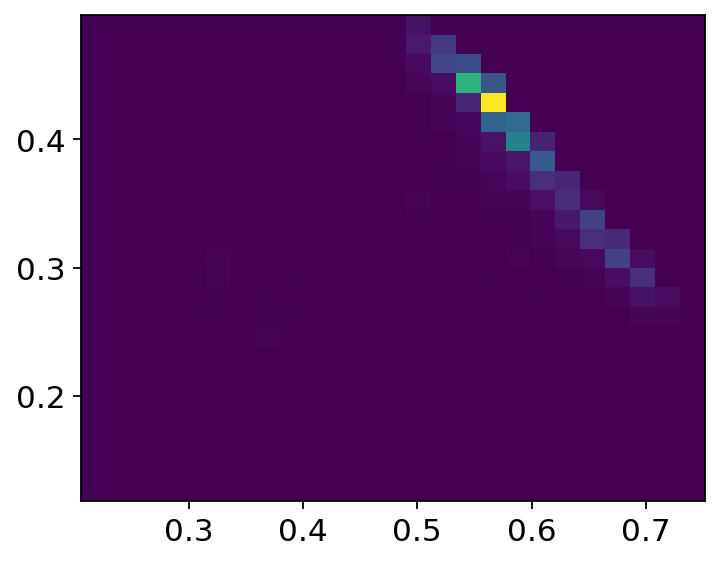

In [22]:
plt.hist2d(x = top_two["second_fraction"], y = top_two["first_fraction"], bins = 25);

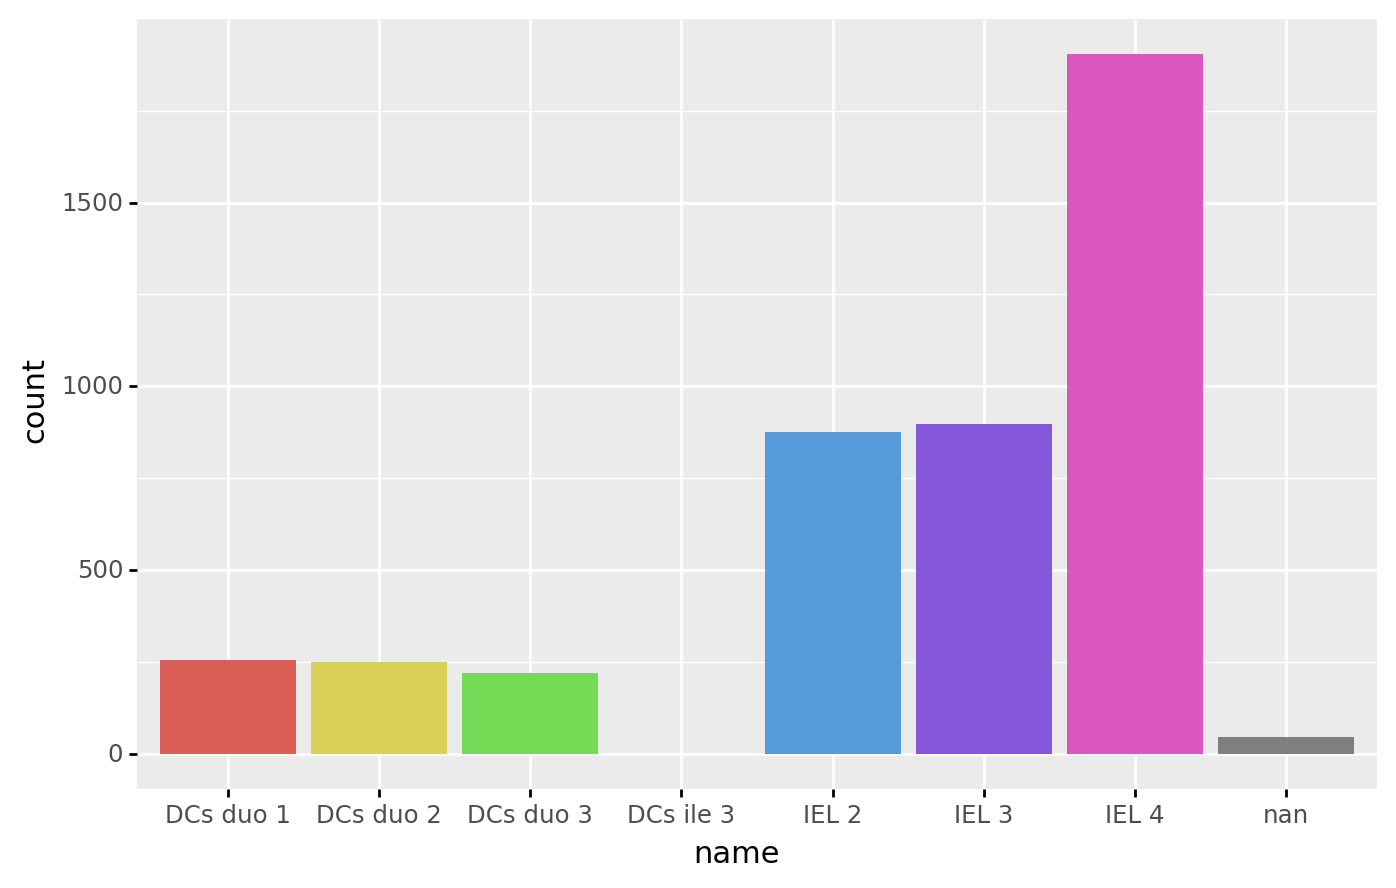

<ggplot: (8744178791316)>

In [23]:
ggplot(top_two, aes(x="name", fill = "name")) + geom_bar() + theme(legend_position = "none", figure_size=(8, 5)) 

In [24]:
gut_data.obs["sample"] = top_two.set_index("cell").loc[gut_data.obs_names]["name"]
gut_data.obs["raw_biotin"] = np.array(gut_data[:,"biotin_interaction"].X.todense()).flatten()

/tmp/ipykernel_269561/2293068472.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


In [25]:
gut_data.shape

(4449, 16329)

## filter out cells that are not aligned to an expected sample pair; filter out sample that has a single cell

In [26]:
gut_data.obs.groupby("sample").count()

n_genes  n_genes_by_counts  total_counts  total_counts_mt  \
sample                                                                 
DCs duo 1      256                256           256              256   
DCs duo 2      249                249           249              249   
DCs duo 3      220                220           220              220   
DCs ile 3        1                  1             1                1   
IEL 2          876                876           876              876   
IEL 3          897                897           897              897   
IEL 4         1904               1904          1904             1904   

           pct_counts_mt  doublet_score  predicted_doublet  potential_doublet  \
sample                                                                          
DCs duo 1            256            256                256                256   
DCs duo 2            249            249                249                249   
DCs duo 3            220            220                220                220   
DCs ile 3              1              1                  1                  1   
IEL 2                876            876                876                876   
IEL 3                897            897                897                897   
IEL 4               1904           1904               1904               1904   

           raw_biotin  
sample                 
DCs duo 1         256  
DCs duo 2         249  
DCs duo 3         220  
DCs ile 3           1  
IEL 2             876  
IEL 3             897  
IEL 4            1904

In [27]:
np.sum(gut_data.obs["sample"] == "DCs ile 3")

1

In [28]:
np.sum(gut_data.obs["sample"].isnull())

46

In [29]:
filtered_gut_data = gut_data.copy()
filtered_gut_data = filtered_gut_data[~filtered_gut_data.obs["sample"].isna(),:]
filtered_gut_data = filtered_gut_data[~(filtered_gut_data.obs["sample"] == 'DCs ile 3'),:]
filtered_gut_data

View of AnnData object with n_obs × n_vars = 4402 × 16329
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet', 'potential_doublet', 'sample', 'raw_biotin'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'scrublet'

using a threshold of 100 for raw biotin to determine if a cell is biotin + or not (the DC samples should not have any biotin)

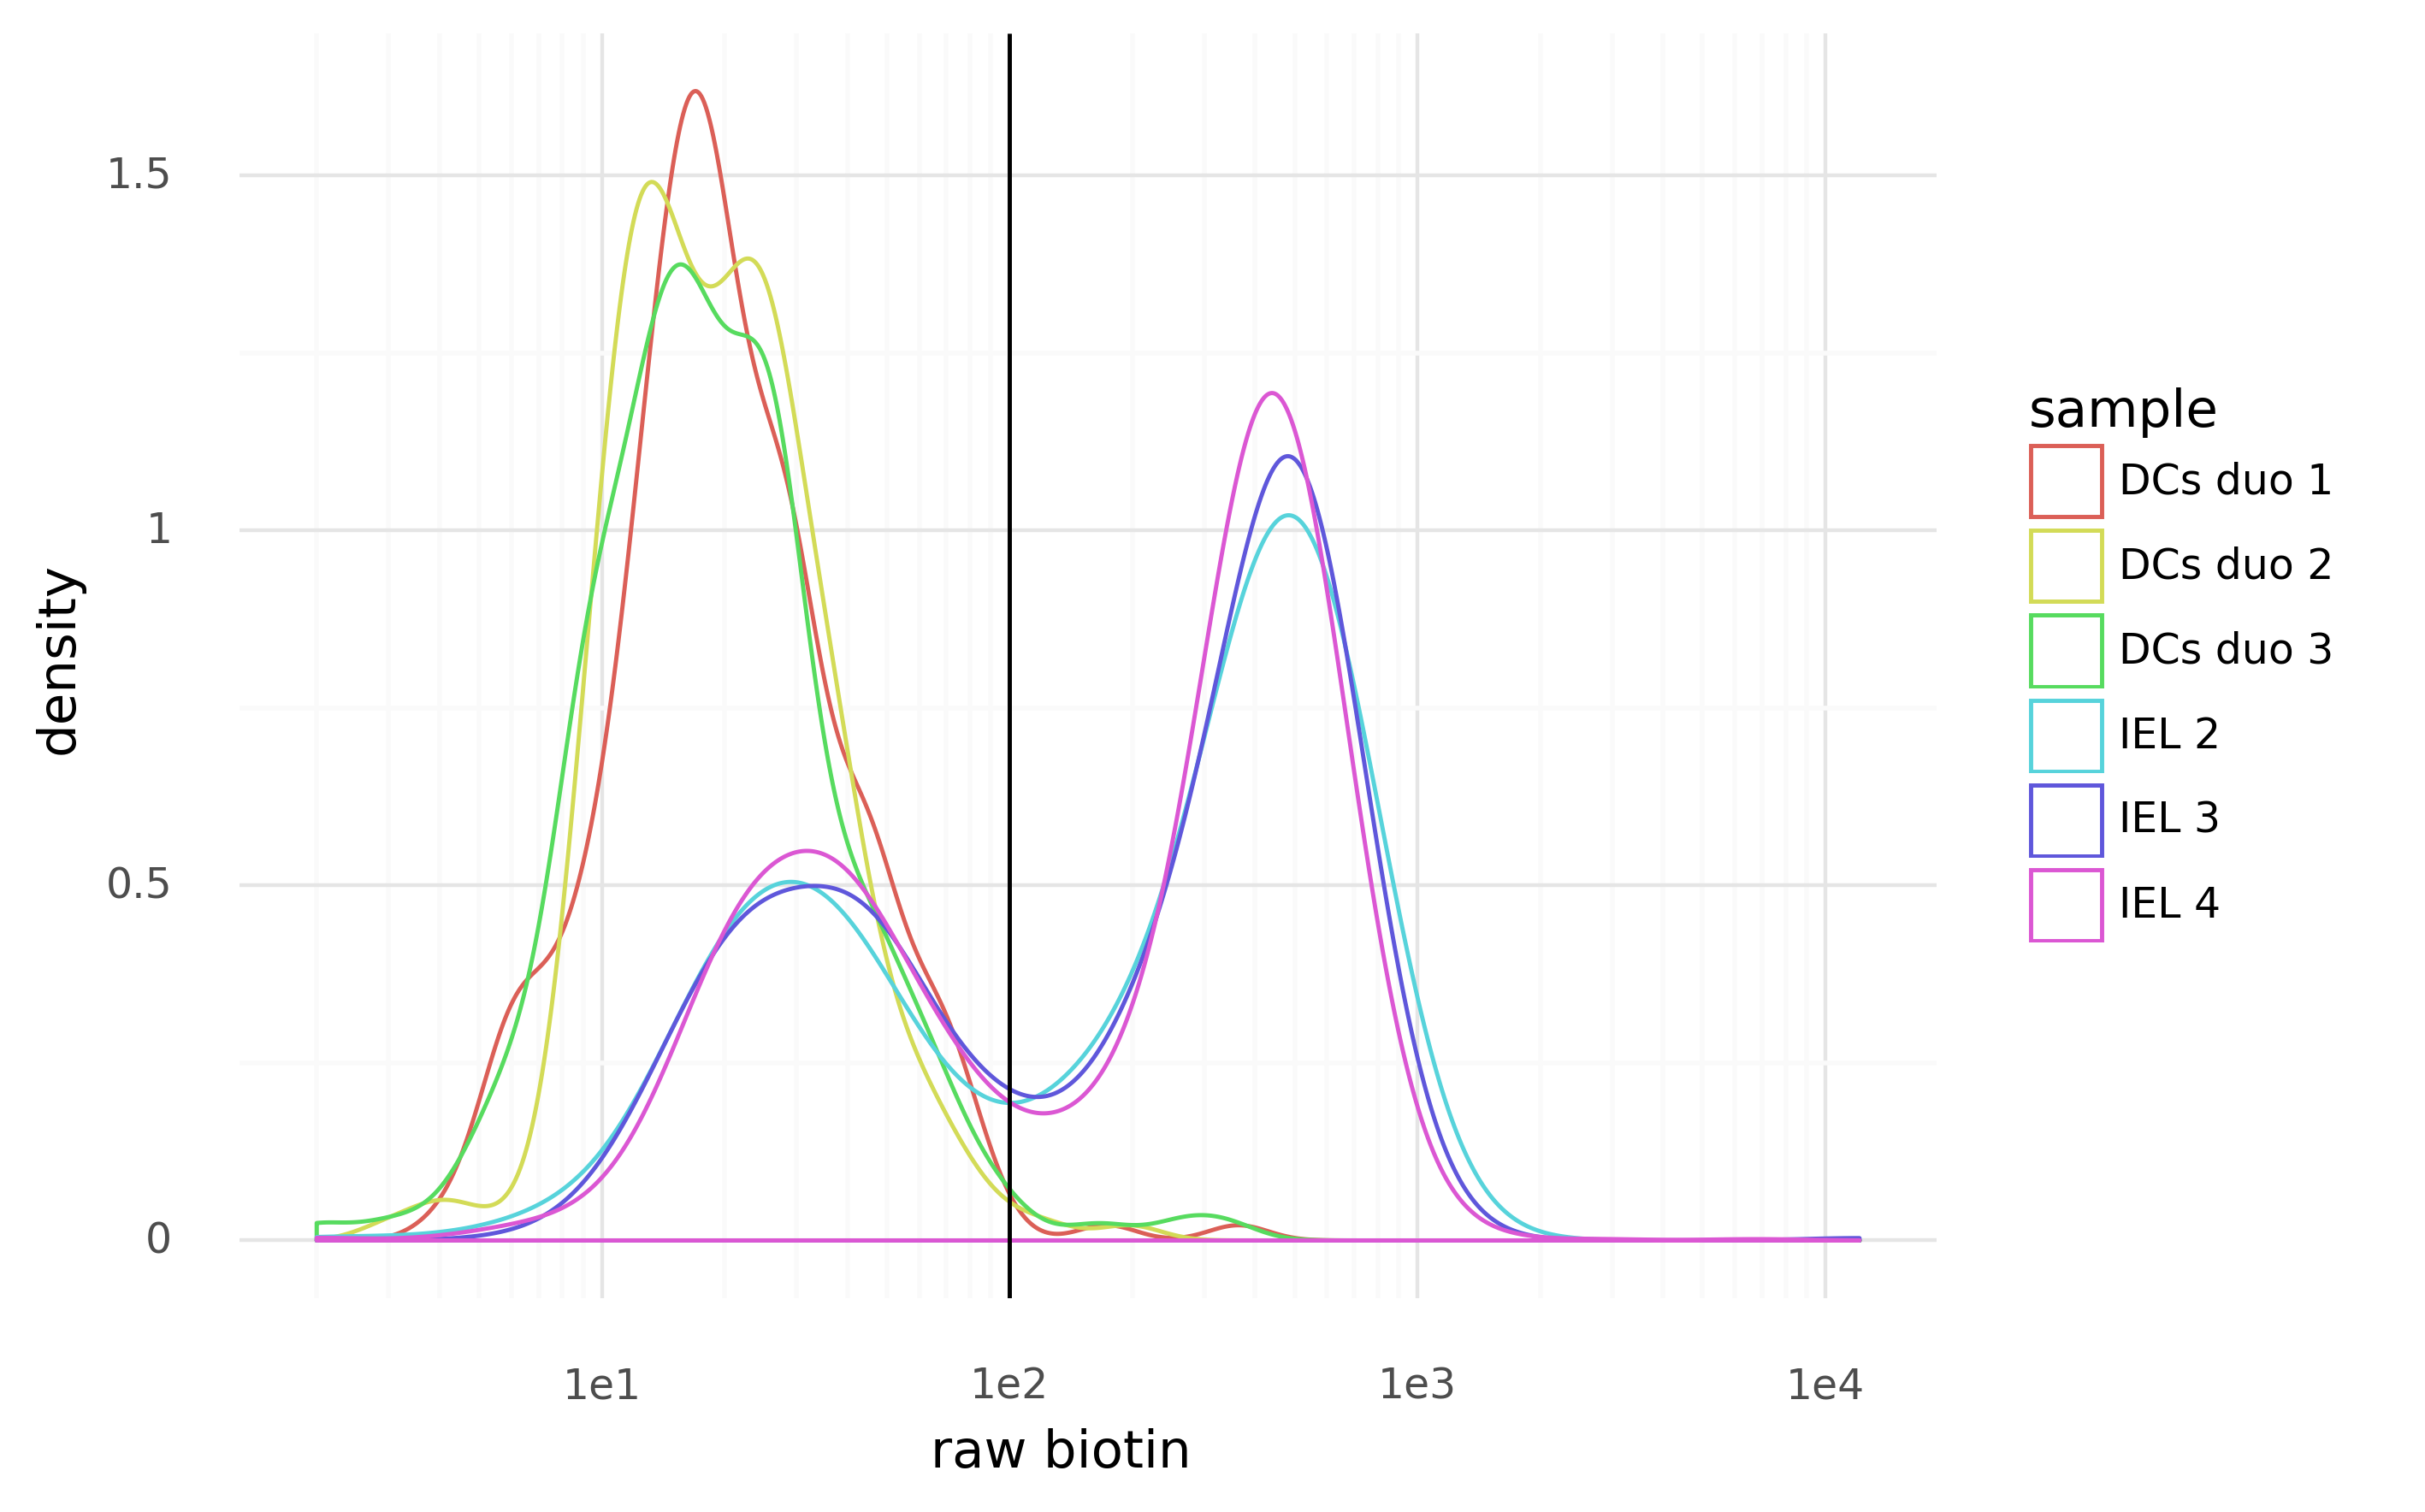

<ggplot: (8744178843856)>

In [30]:
ggplot(filtered_gut_data.obs, aes(x="raw_biotin", color = "sample")) + geom_density() + \
theme_minimal() + theme(dpi=200) + scale_x_log10() + geom_vline(xintercept = 100) + labs(x="raw biotin")

## normalize cells by diving number of biotin HTO counts by number of sample HTO counts (average between the two sample HTOs)

In [31]:
top_two["sample_avg"] =  (top_two["first_count"] + top_two["second_count"])/2 
top_two.head()

cell      indices   name  first second  first_fraction  \
0  AAACCTGAGCCAGAAC-1  C0308 C0307  IEL 4  C0308  C0307        0.418592   
0  AAACCTGCACTTCGAA-1  C0308 C0307  IEL 4  C0308  C0307        0.466581   
0  AAACCTGGTACTTAGC-1  C0308 C0307  IEL 4  C0308  C0307        0.392958   
0  AAACCTGGTGTCGCTG-1  C0305 C0306  IEL 3  C0305  C0306        0.310945   
0  AAACCTGTCGGCCGAT-1  C0305 C0306  IEL 3  C0305  C0306        0.295233   

   second_fraction  second_count  first_count  sample_avg  
0         0.578475        3155.0       2283.0      2719.0  
0         0.529049        2058.0       1815.0      1936.5  
0         0.573239         407.0        279.0       343.0  
0         0.641791         258.0        125.0       191.5  
0         0.689390        1345.0        576.0       960.5

In [32]:
filtered_gut_data.obs["cell_norm_biotin"] = filtered_gut_data.obs["raw_biotin"]/top_two.set_index("cell").loc[
    filtered_gut_data.obs_names]["sample_avg"]

/tmp/ipykernel_269561/130277123.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


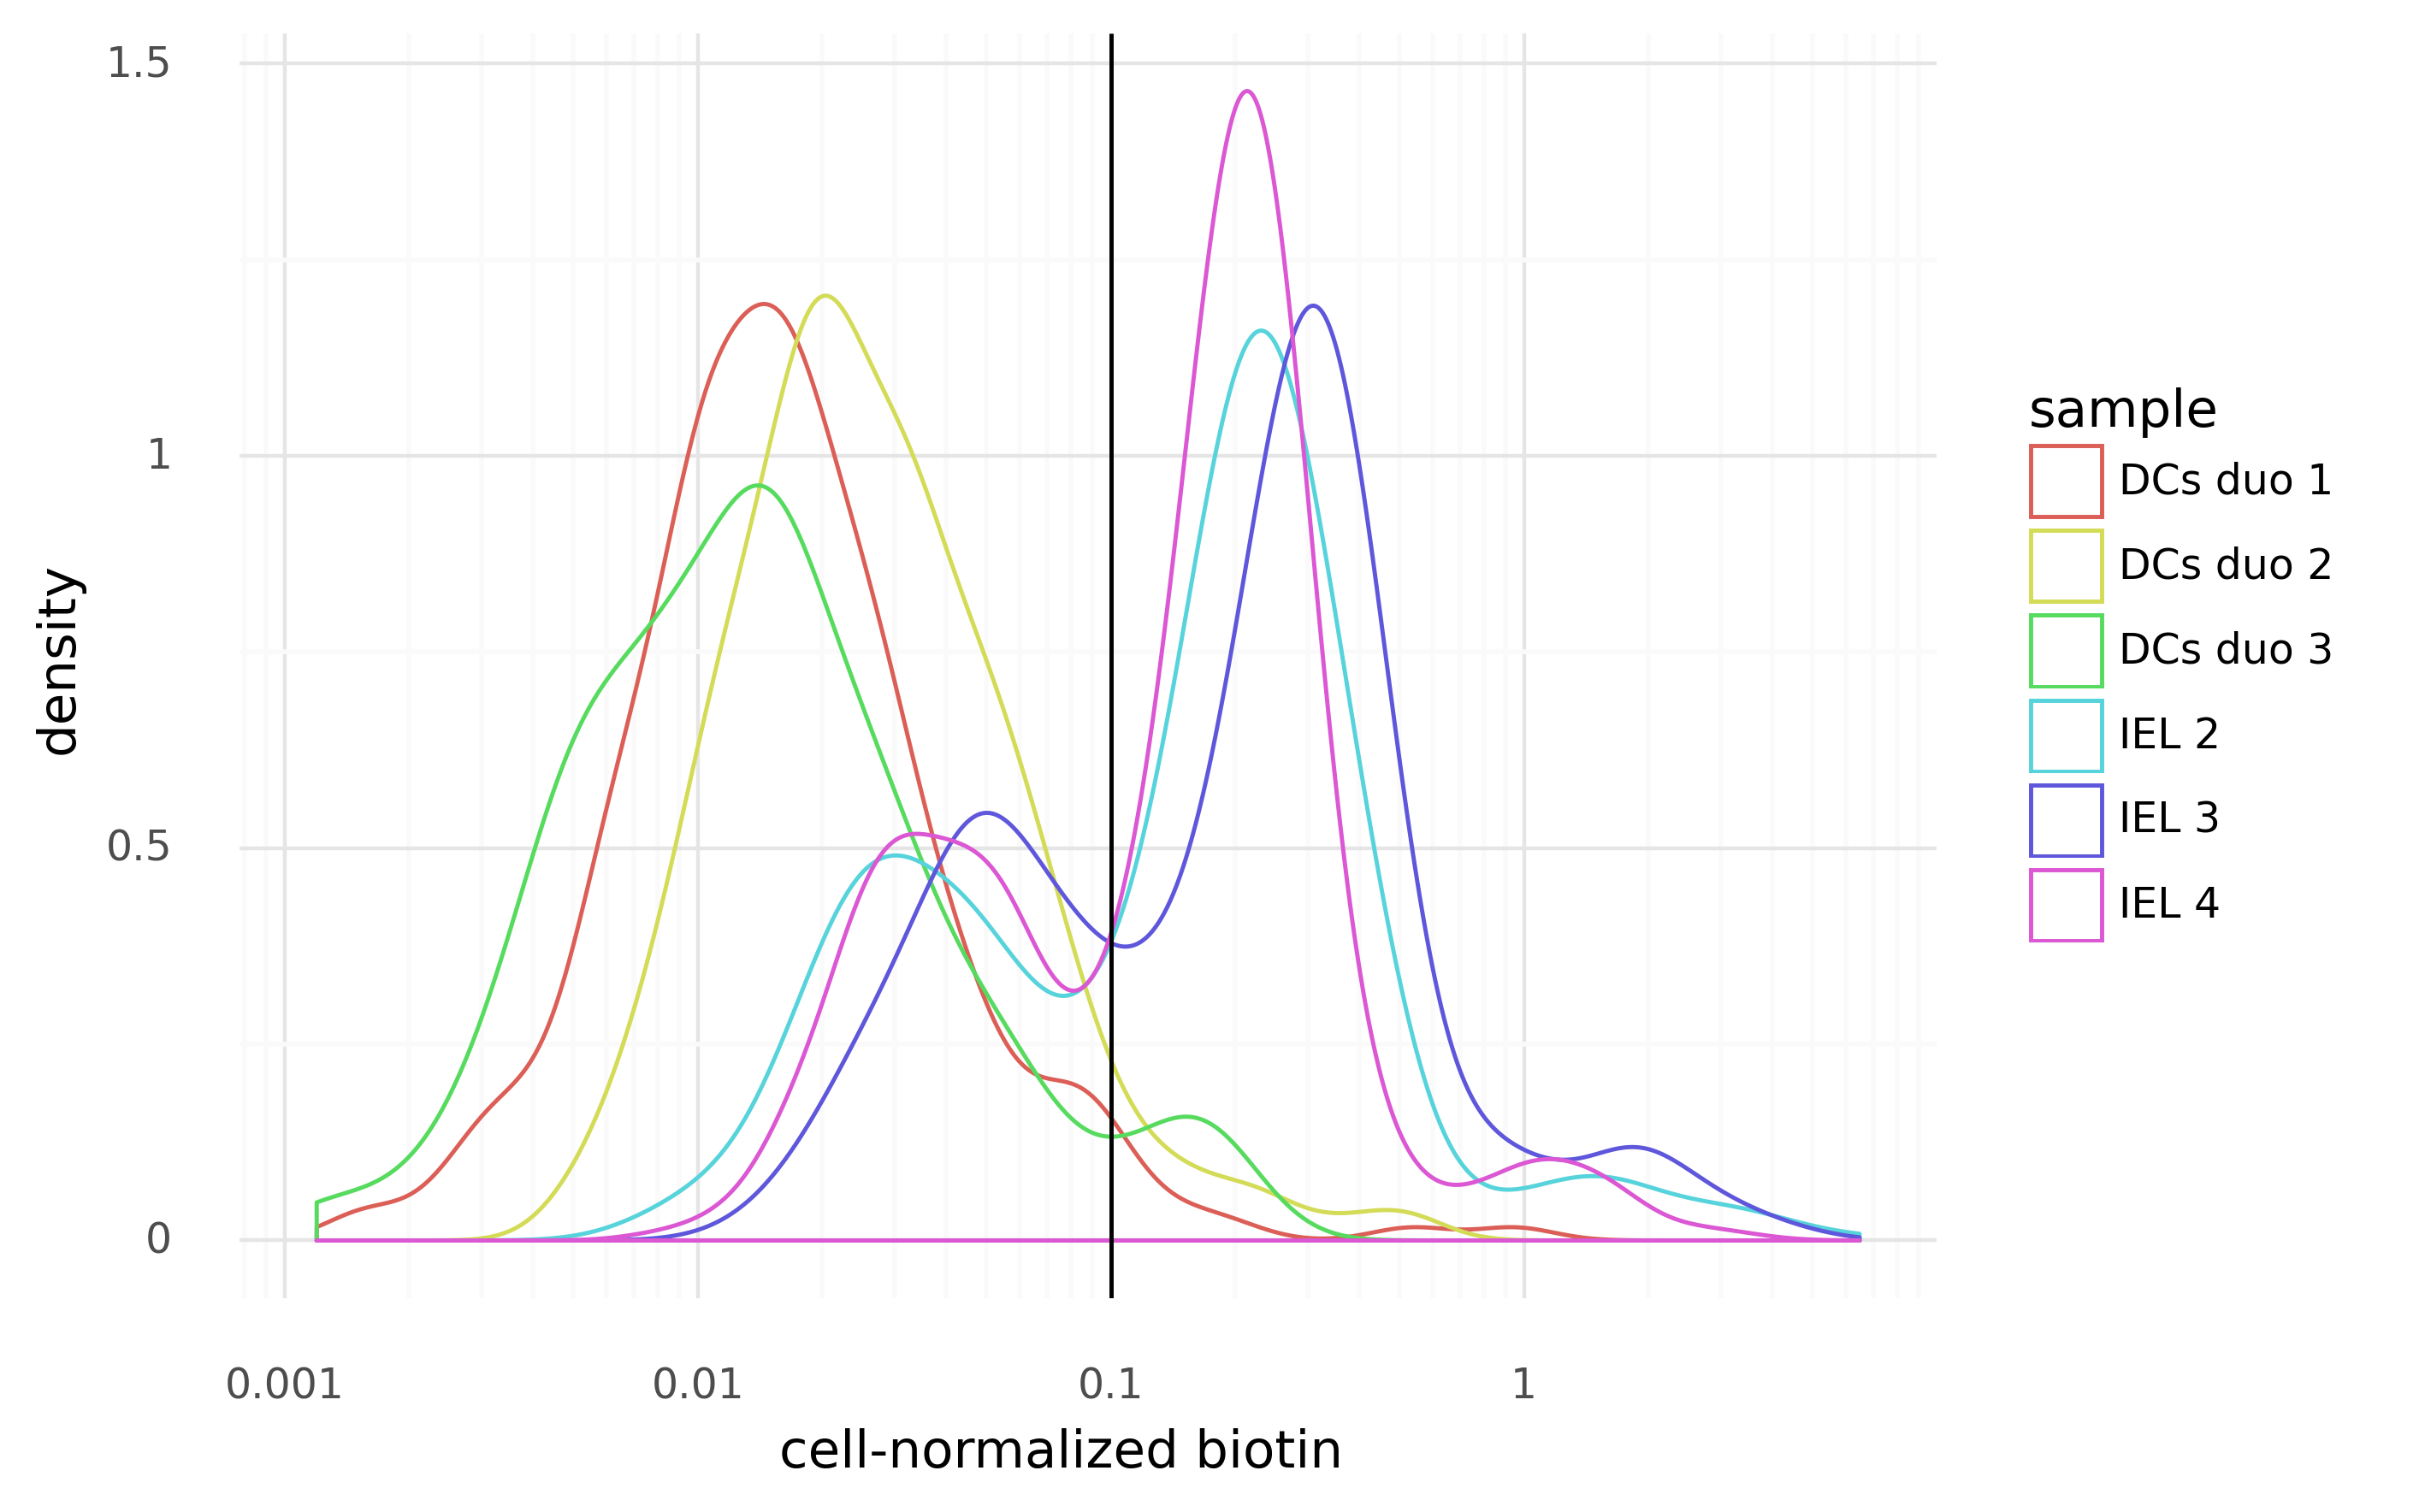

<ggplot: (8744178737830)>

In [33]:
ggplot(filtered_gut_data.obs, aes(x="cell_norm_biotin", color = "sample")) + geom_density() + \
theme_minimal() + theme(dpi=200) + scale_x_log10() + geom_vline(xintercept = 0.1) + labs(x="cell-normalized biotin")

In [34]:
## remove custom objects from var
filtered_gut_data = filtered_gut_data[:,filtered_gut_data.var["feature_types"] == "Gene Expression"]
filtered_gut_data

View of AnnData object with n_obs × n_vars = 4402 × 16318
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet', 'potential_doublet', 'sample', 'raw_biotin', 'cell_norm_biotin'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'scrublet'

In [35]:
filtered_gut_data.obs["sample_type"] = filtered_gut_data.obs["sample"].str.split(" ").str[0]

/tmp/ipykernel_269561/1393495447.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


## normalize data using Pearson residuals
- tried multiple values of theta, chose theta of 1 because after normalization, mean gene values centered at 0, variances centered at 1

In [36]:
filtered_gut_data.layers["raw_counts"] = filtered_gut_data.X.copy()

In [37]:
sc.__version__

'1.9.1'

In [38]:
sc.experimental.pp.normalize_pearson_residuals(filtered_gut_data, theta = 1, inplace = True)
filtered_gut_data.layers["pearson_theta_1"] = filtered_gut_data.X.copy()

/Genomics/grid/users/skwalker/tcr_env/lib/python3.9/site-packages/scanpy/experimental/pp/_normalization.py:59: RuntimeWarning: invalid value encountered in true_divide


filter out some more low-count genes

In [39]:
filtered_gut_data.X = filtered_gut_data.layers["raw_counts"].copy()
sc.pp.filter_genes(filtered_gut_data, min_cells = 10)

/Genomics/grid/users/skwalker/tcr_env/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Genomics/grid/users/skwalker/tcr_env/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Genomics/grid/users/skwalker/tcr_env/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 333'. Pick better value with 'binwidth'.
/Genomics/grid/users/skwalker/tcr_env/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


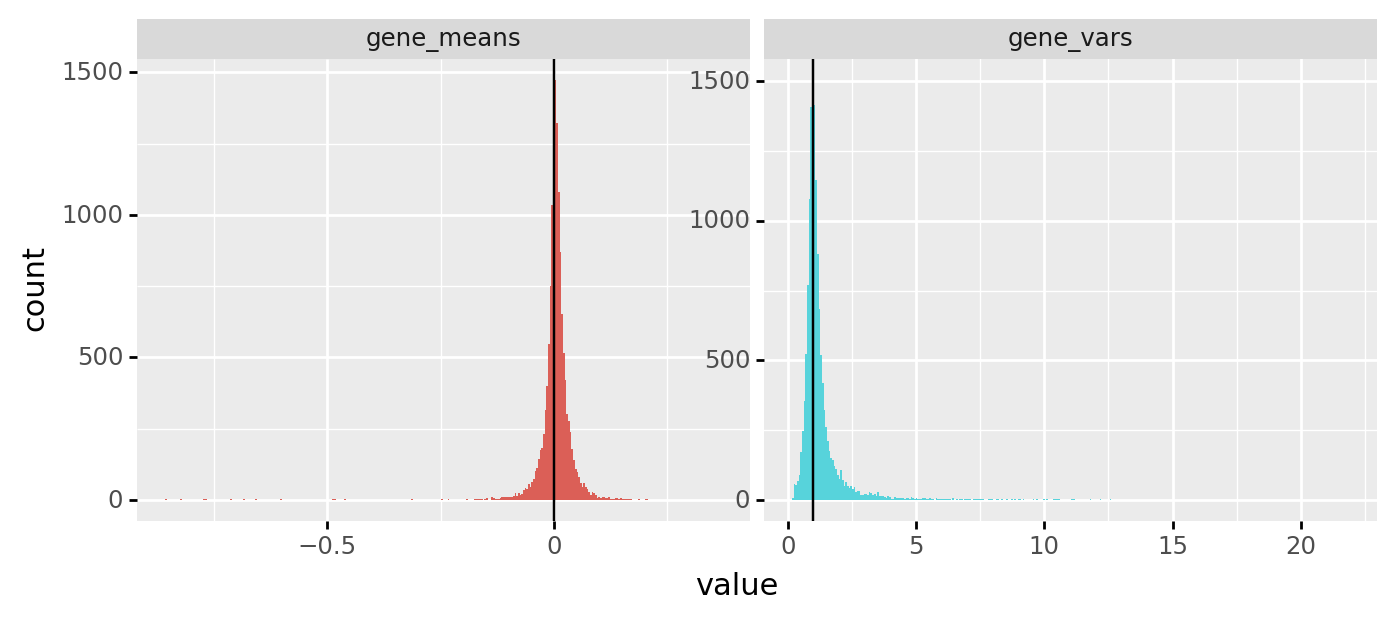

<ggplot: (8744179401777)>

In [40]:
def make_mean_var(layer, ad = filtered_gut_data):
     return pd.DataFrame({"gene_means": np.nanmean(ad.layers[layer], axis = 0),
                          "gene_vars": np.nanvar(ad.layers[layer], axis = 0)}).melt(ignore_index=False)

ggplot(make_mean_var("pearson_theta_1"), aes(x="value", fill="variable")) + geom_histogram() + geom_vline(
pd.DataFrame({"variable": ["gene_means", "gene_vars"], "pos": [0, 1]}), aes(xintercept="pos")) \
+ facet_wrap("~ variable", scales="free") + theme(legend_position = "none", figure_size=(8,3))

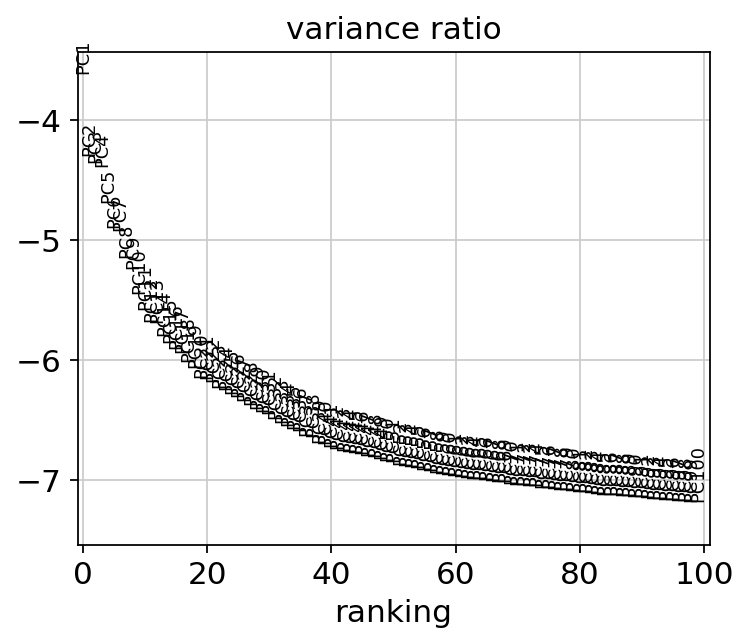

In [41]:
filtered_gut_data.X = filtered_gut_data.layers["pearson_theta_1"].copy()
sc.tl.pca(filtered_gut_data, n_comps=100, svd_solver='arpack')
sc.pl.pca_variance_ratio(filtered_gut_data, 100, log=True, )

In [42]:
sc.pp.neighbors(filtered_gut_data, n_neighbors=30, n_pcs=50, use_rep='X_pca')
sc.tl.leiden(filtered_gut_data, resolution=0.7)
sc.tl.umap(filtered_gut_data)

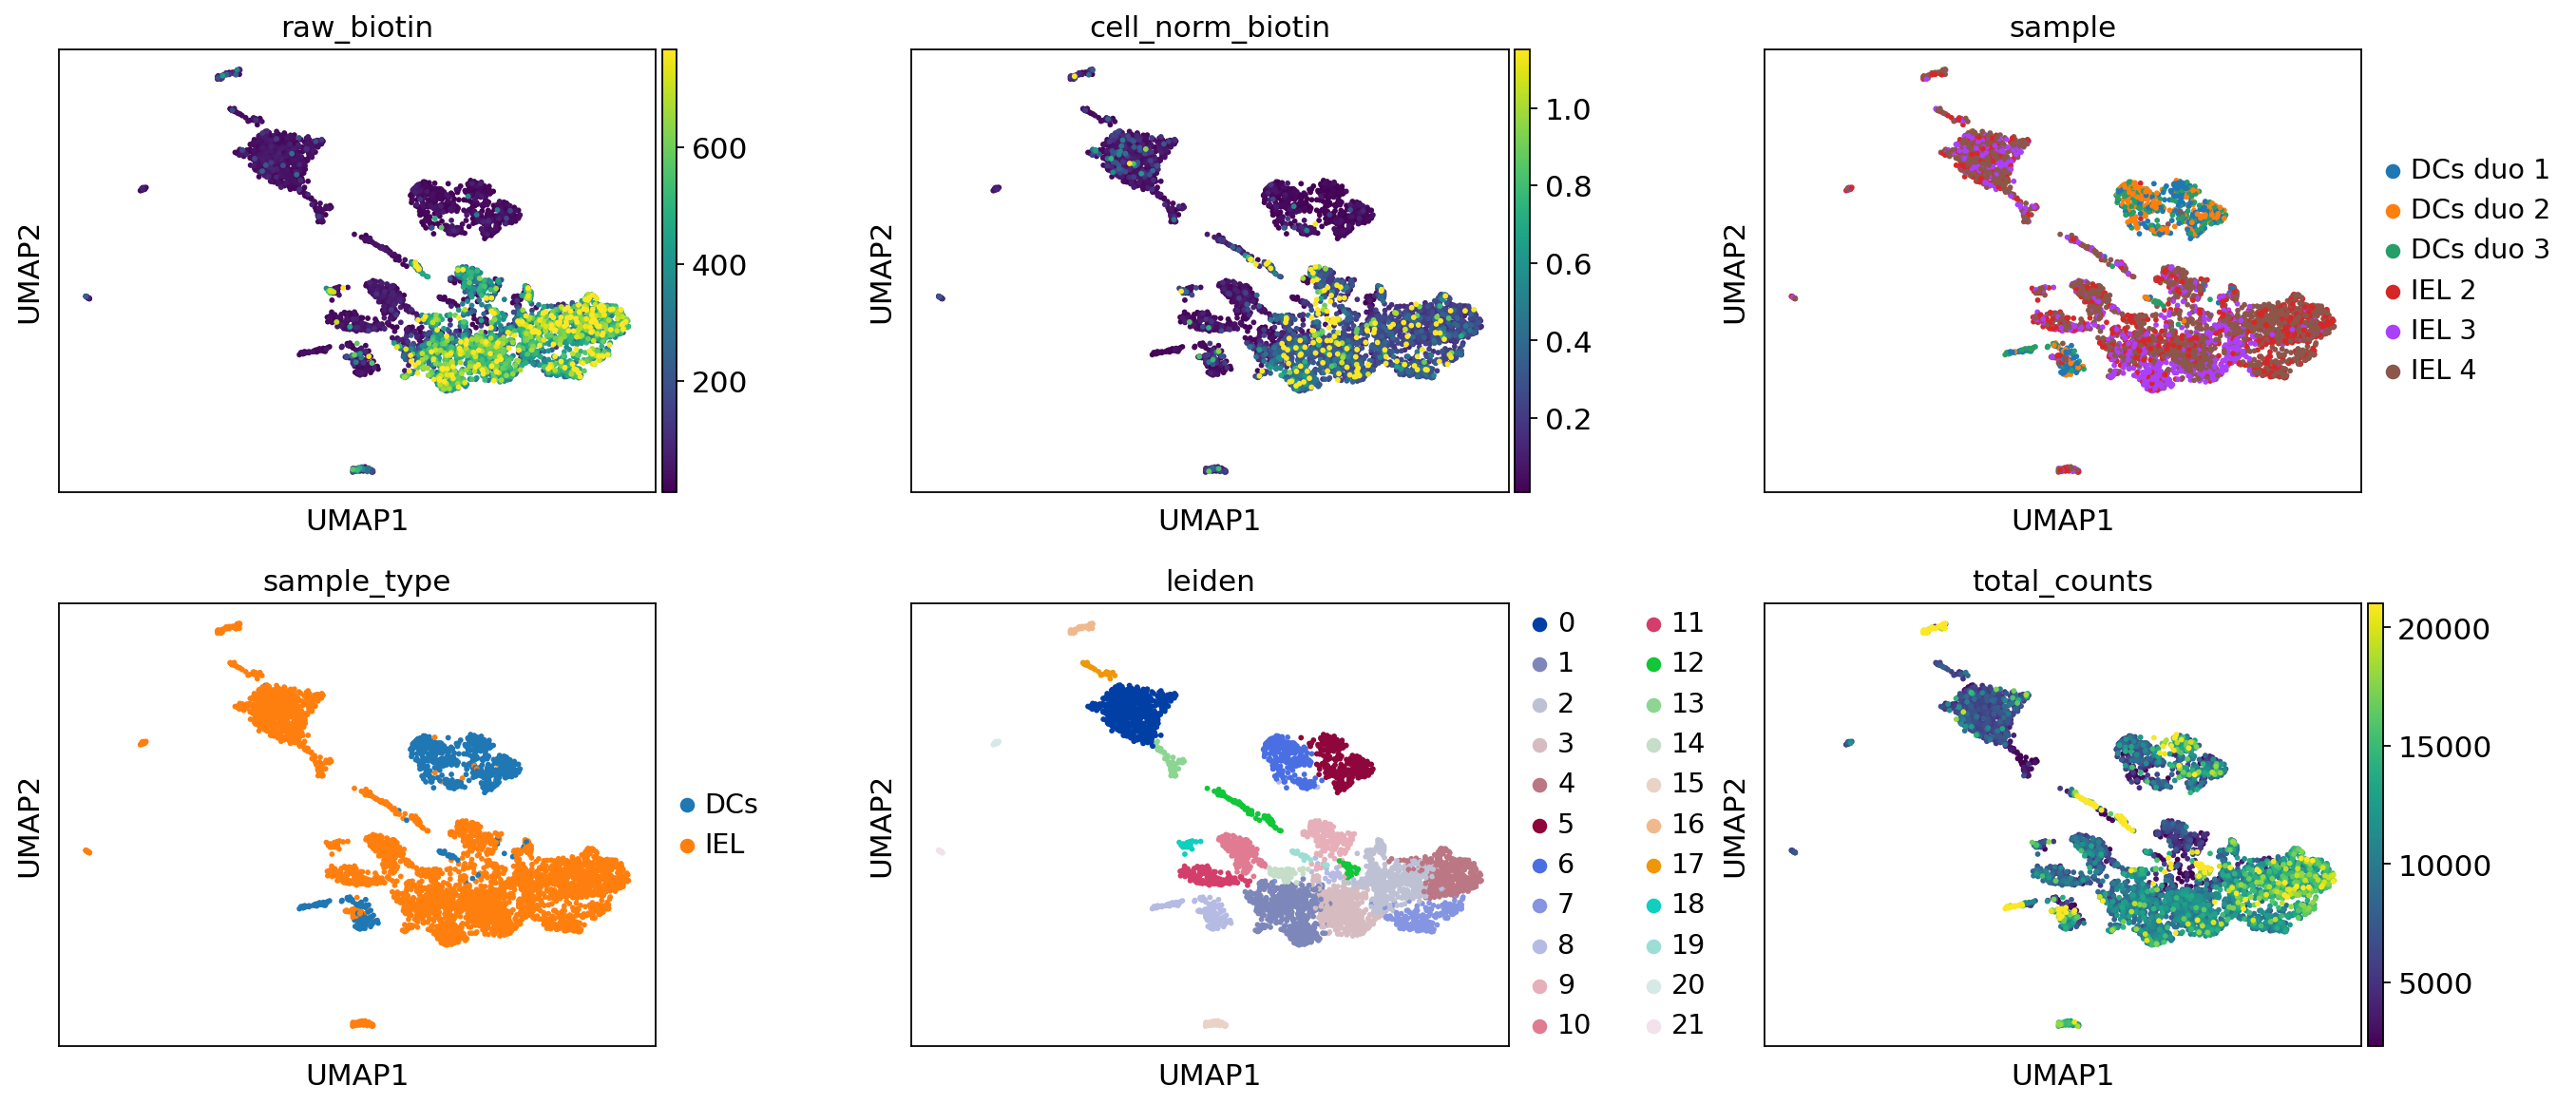

In [43]:
sc.pl.umap(filtered_gut_data, color = ["raw_biotin", "cell_norm_biotin", "sample", "sample_type",
                                       "leiden", "total_counts"], ncols = 3, wspace=0.3, vmin="p3", vmax="p97")

## Filter to IELs

In [44]:
iel_only = filtered_gut_data.copy()
iel_only = iel_only[iel_only.obs.sample_type == "IEL",:]
iel_only

View of AnnData object with n_obs × n_vars = 3677 × 14332
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet', 'potential_doublet', 'sample', 'raw_biotin', 'cell_norm_biotin', 'sample_type', 'leiden'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'scrublet', 'pearson_residuals_normalization', 'pca', 'neighbors', 'leiden', 'umap', 'sample_colors', 'sample_type_colors', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_counts', 'pearson_theta_1'
    obsp: 'distances', 'connectivities'

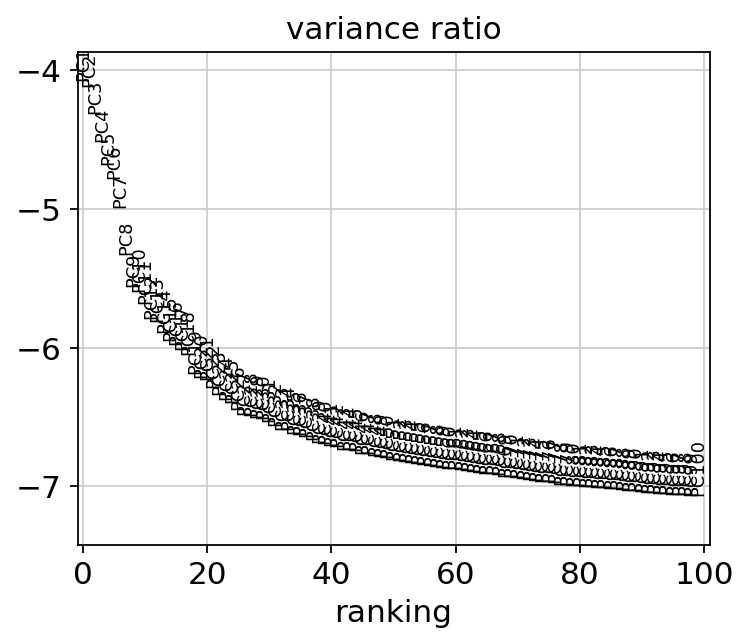

In [45]:
iel_only.X = iel_only.layers["pearson_theta_1"].copy()
sc.tl.pca(iel_only, n_comps=100, svd_solver='arpack')
sc.pl.pca_variance_ratio(iel_only, 100, log=True, )

In [46]:
sc.pp.neighbors(iel_only, n_neighbors=30, n_pcs=40, use_rep='X_pca')
sc.tl.leiden(iel_only, resolution=1)
sc.tl.umap(iel_only)

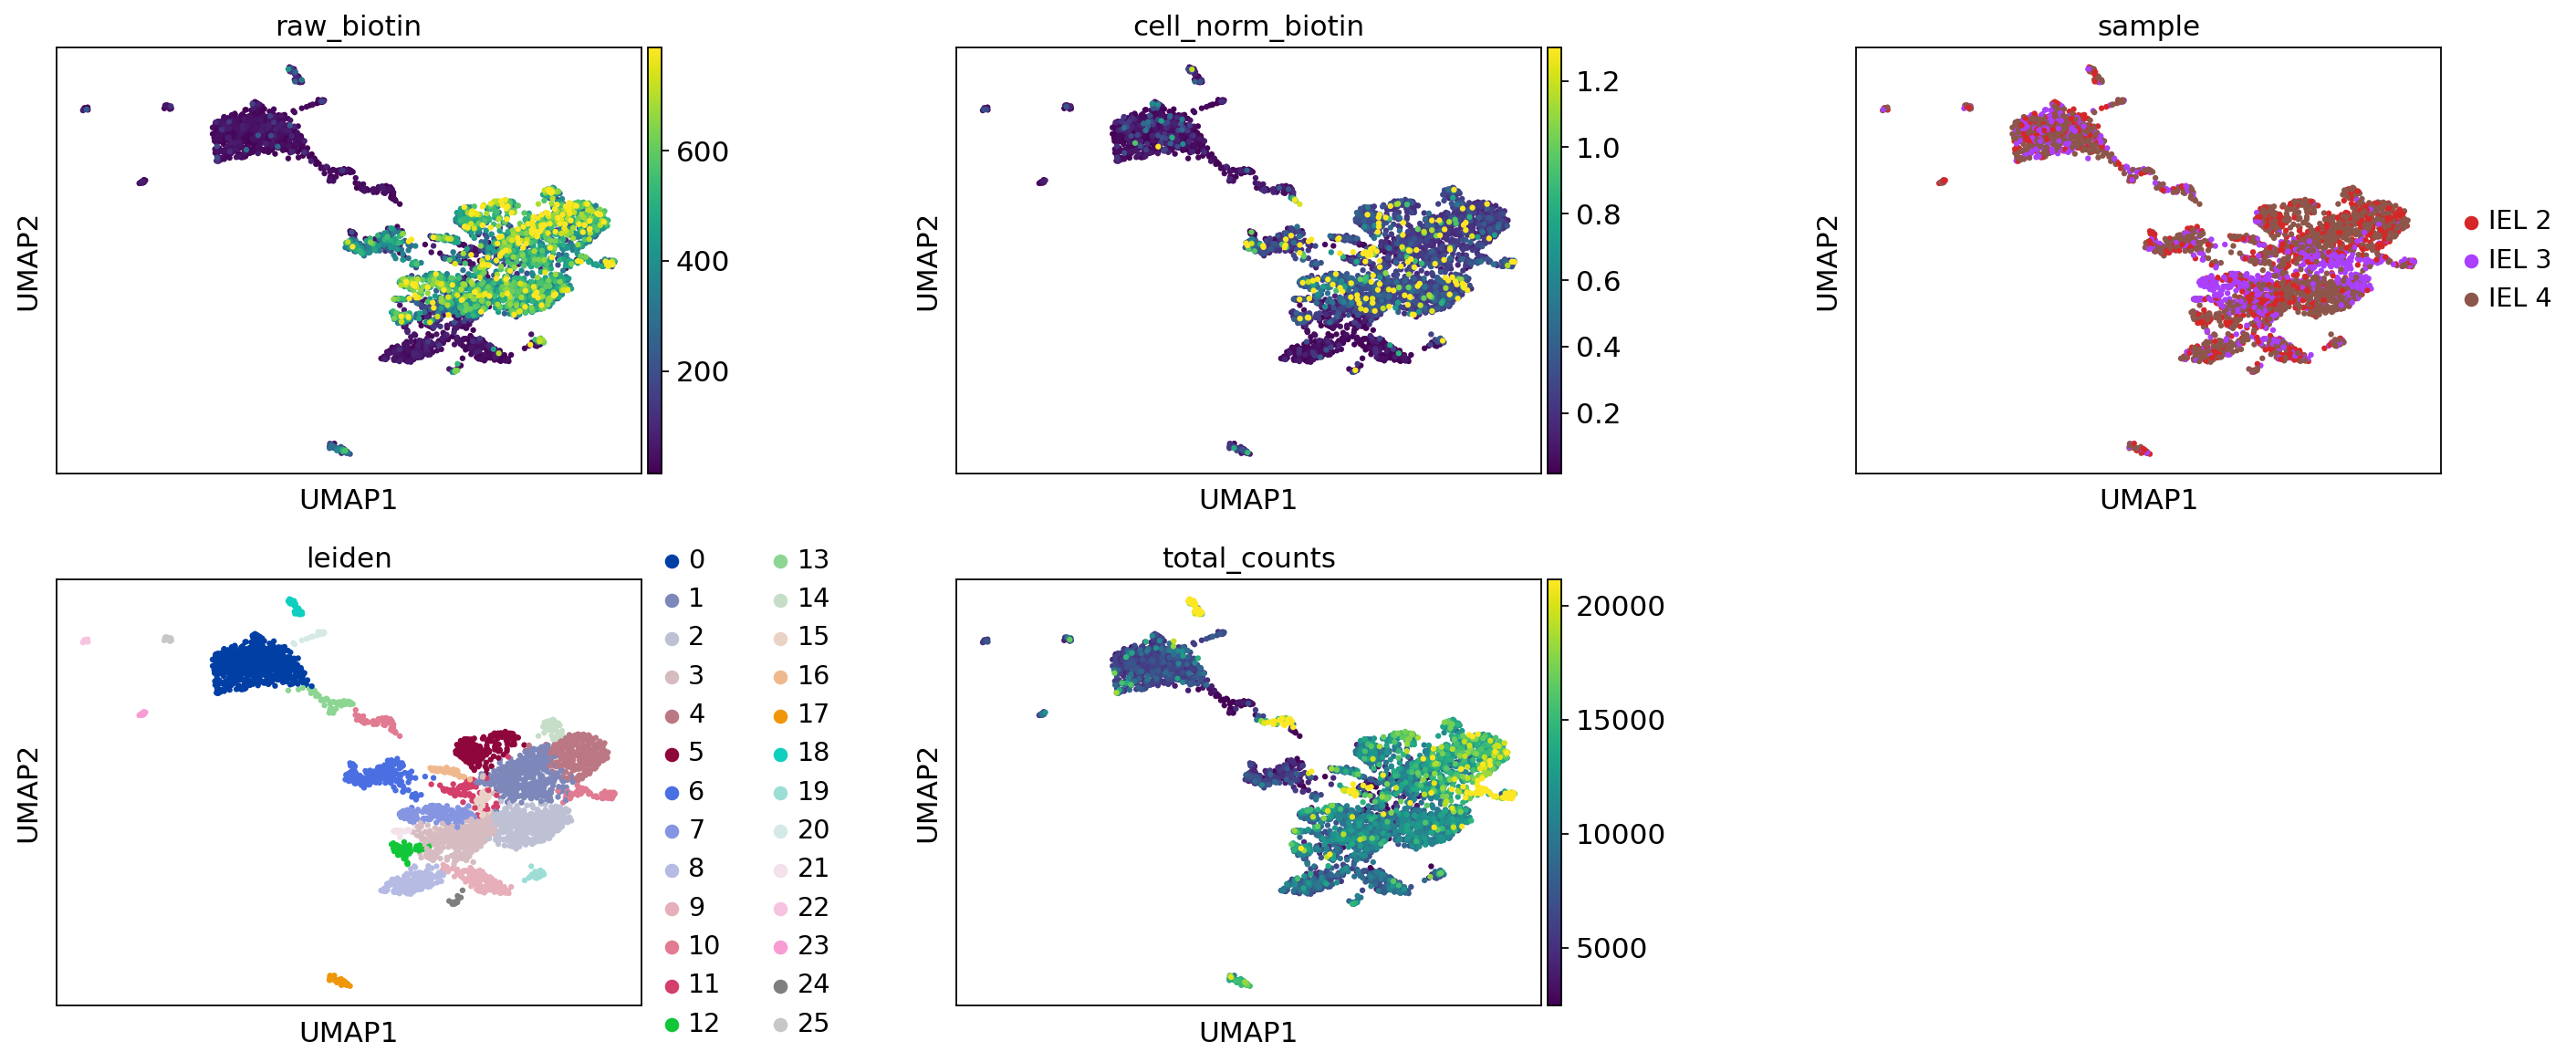

In [47]:
sc.pl.umap(iel_only, color = ["raw_biotin", "cell_norm_biotin", "sample",  "leiden", "total_counts"],
          ncols = 3, wspace = 0.4, vmin="p3", vmax="p97")

## <font color = "maroon"> supplemental figure

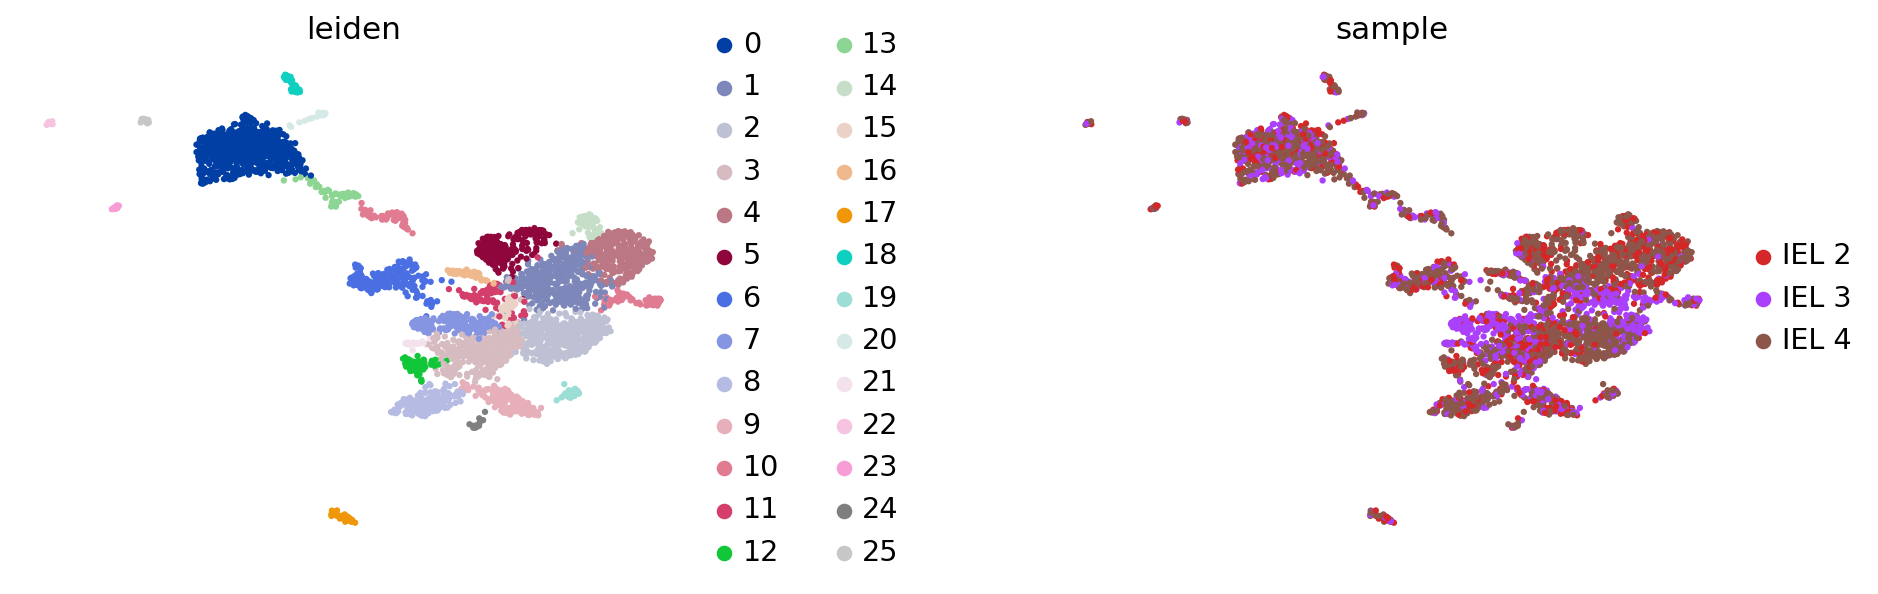

In [48]:
sc.settings.figdir="paper_figures/supplemental/"
sc.pl.umap(iel_only, color = ["leiden", "sample"], ncols = 3, wspace = 0.4, vmin="p3", 
           vmax="p97", save="_sample_cluster.pdf", frameon=False)

## <font color = "navy"> supplemental figure

In [49]:
iel_only.obs.sort_values("leiden")["leiden"]

CACCACTTCAACTCTT-1     0
CACACCTGTAAACCTC-1     0
TACAGTGCACGAGAGT-1     0
CACACTCCAGTATAAG-1     0
TACAGTGAGAAGGCCT-1     0
                      ..
ATAAGAGGTTTACTCT-1    25
TGACTAGTCTCCCTGA-1    25
TCTATTGGTGAGGGAG-1    25
CGGGTCAAGCTGTTCA-1    25
AGCAGCCTCCAAACTG-1    25
Name: leiden, Length: 3677, dtype: category
Categories (26, object): ['0', '1', '2', '3', ..., '22', '23', '24', '25']

In [50]:
og_leiden_cats = pd.api.types.CategoricalDtype(categories = np.flip(np.array([ str(x) for x in range(26)])),
                                               ordered = True)

In [51]:
iel_only.obs["leiden "] = iel_only.obs["leiden"].astype(og_leiden_cats)

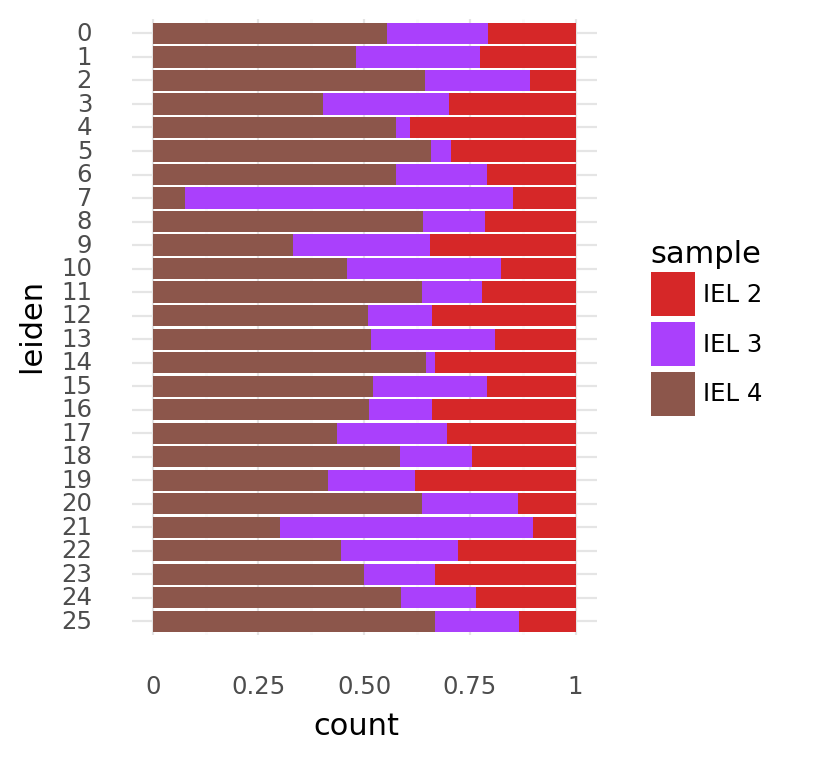

<ggplot: (8744178677526)>

In [52]:
bar = ggplot(iel_only.obs, aes(x="leiden ", fill="sample")) + geom_bar(position = "fill") + theme_minimal() + theme(
    figure_size=(3,4))  + scale_fill_manual(iel_only.uns["sample_colors"]) + coord_flip()
bar

In [53]:
ggsave(bar, "paper_figures/supplemental/barplot_sample_composition.pdf")

/Genomics/grid/users/skwalker/tcr_env/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 3 x 4 in image.
/Genomics/grid/users/skwalker/tcr_env/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: paper_figures/supplemental/barplot_sample_composition.pdf


## log-scale normalized biotin

In [54]:
fifth_pctile_biotin = np.quantile(iel_only.obs["cell_norm_biotin"], 0.05)
fifth_pctile_biotin

0.022287682443857194

In [55]:
iel_only.obs["normalized biotin"] = np.log10((1e5 * iel_only.obs["cell_norm_biotin"]) + fifth_pctile_biotin)

In [56]:
iel_only.obs["og normalized biotin"] = np.log10(1e5*(iel_only.obs["cell_norm_biotin"] + fifth_pctile_biotin))

In [57]:
spearmanr(iel_only.obs["og normalized biotin"], iel_only.obs["normalized biotin"]  )

SpearmanrResult(correlation=0.9999999999999998, pvalue=0.0)

In [58]:
norm_biotinpos_threshold = np.log10((1e5*0.1) + fifth_pctile_biotin)
norm_biotinpos_threshold

4.000000967940672

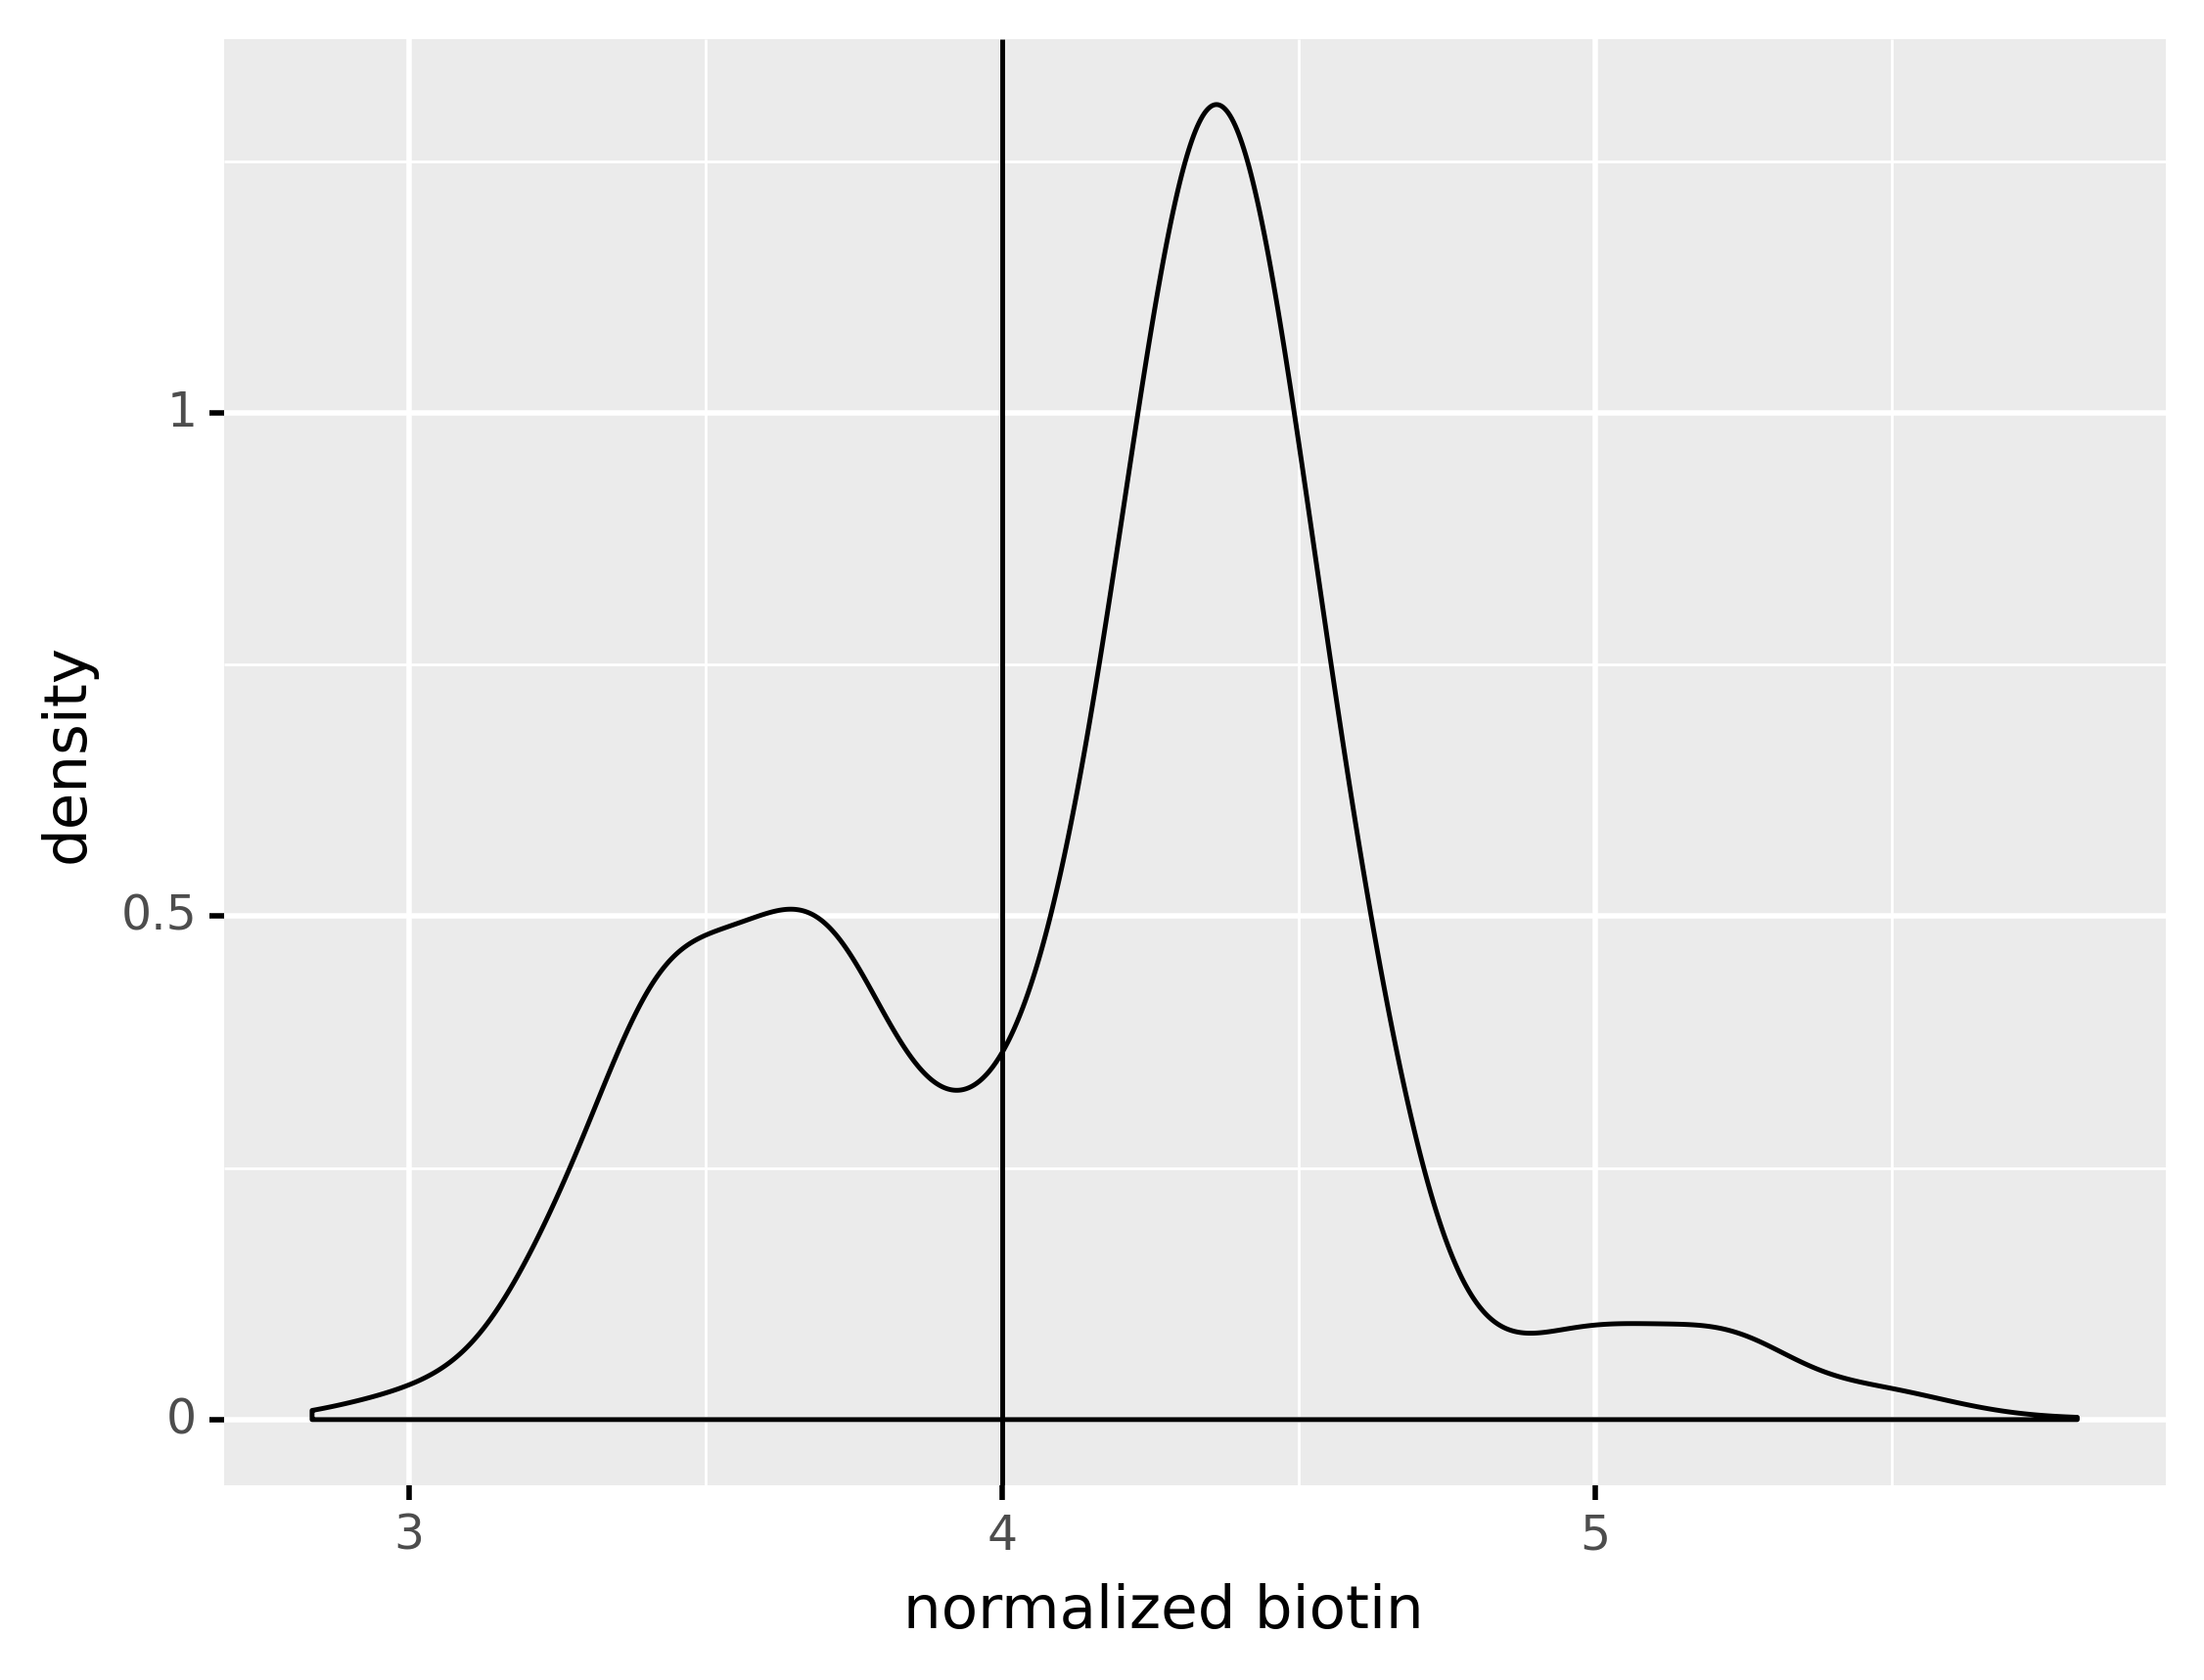

<ggplot: (8744178754479)>

In [59]:
ggplot(iel_only.obs, aes(x="normalized biotin")) + geom_density() + geom_vline(
    xintercept = norm_biotinpos_threshold) + theme(dpi=200)

## cluster 10 needs to be split in 2:

## figure 4, panel G (right)

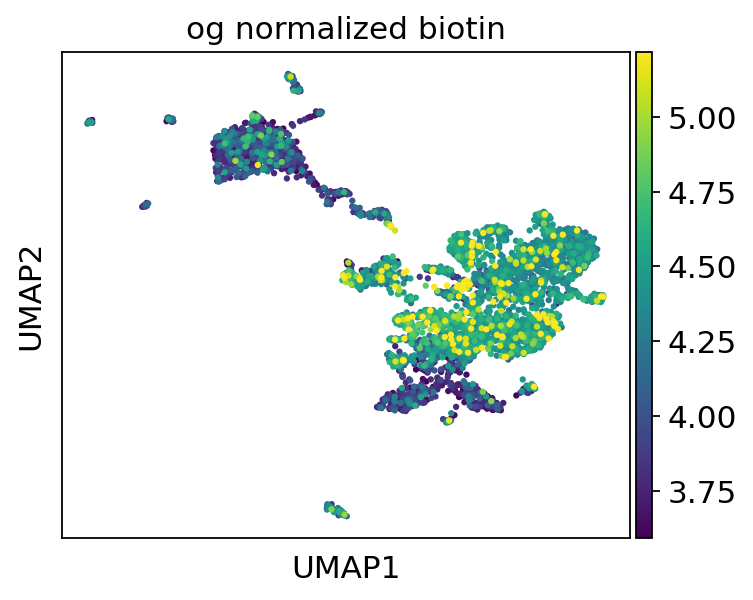

In [60]:
sc.pl.umap(iel_only, color="og normalized biotin", cmap="viridis",  vmin="p2", vmax="p98")

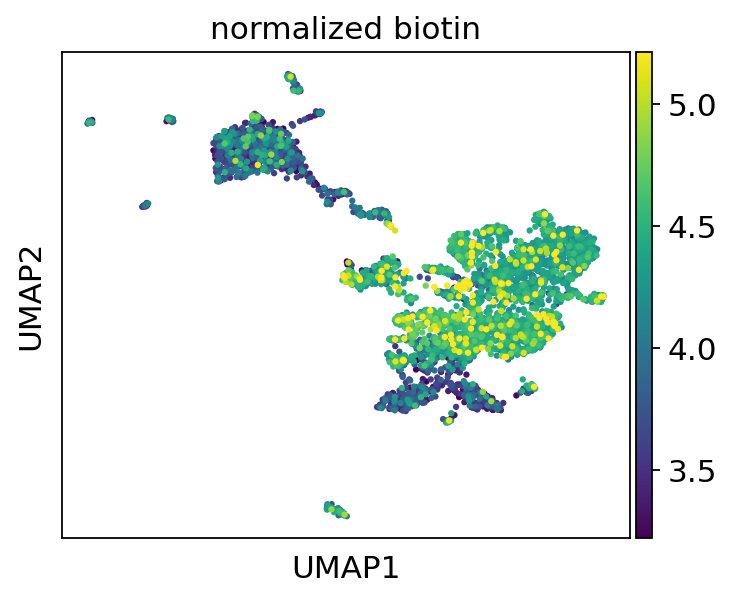

In [61]:
sc.pl.umap(iel_only, color="normalized biotin", cmap="viridis", vmin="p2", vmax="p98")

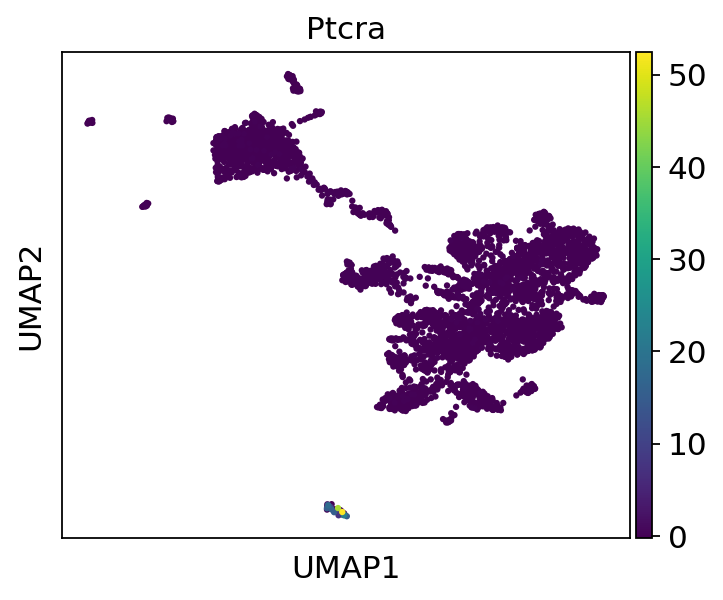

In [62]:
sc.pl.umap(iel_only, color="Ptcra", cmap="viridis")

/Genomics/grid/users/skwalker/tcr_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.


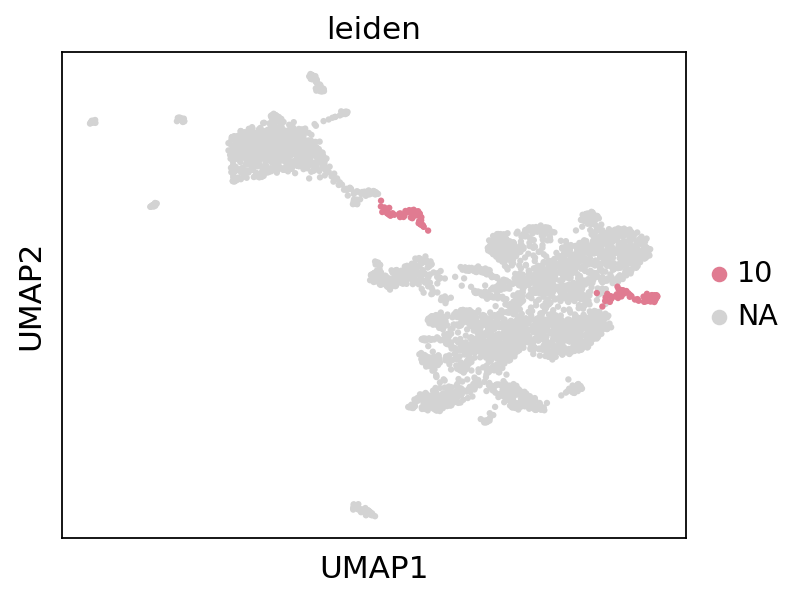

In [63]:
sc.pl.umap(iel_only, color = "leiden", groups=["10"])

/Genomics/grid/users/skwalker/tcr_env/lib/python3.9/site-packages/scanpy/tools/_leiden.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


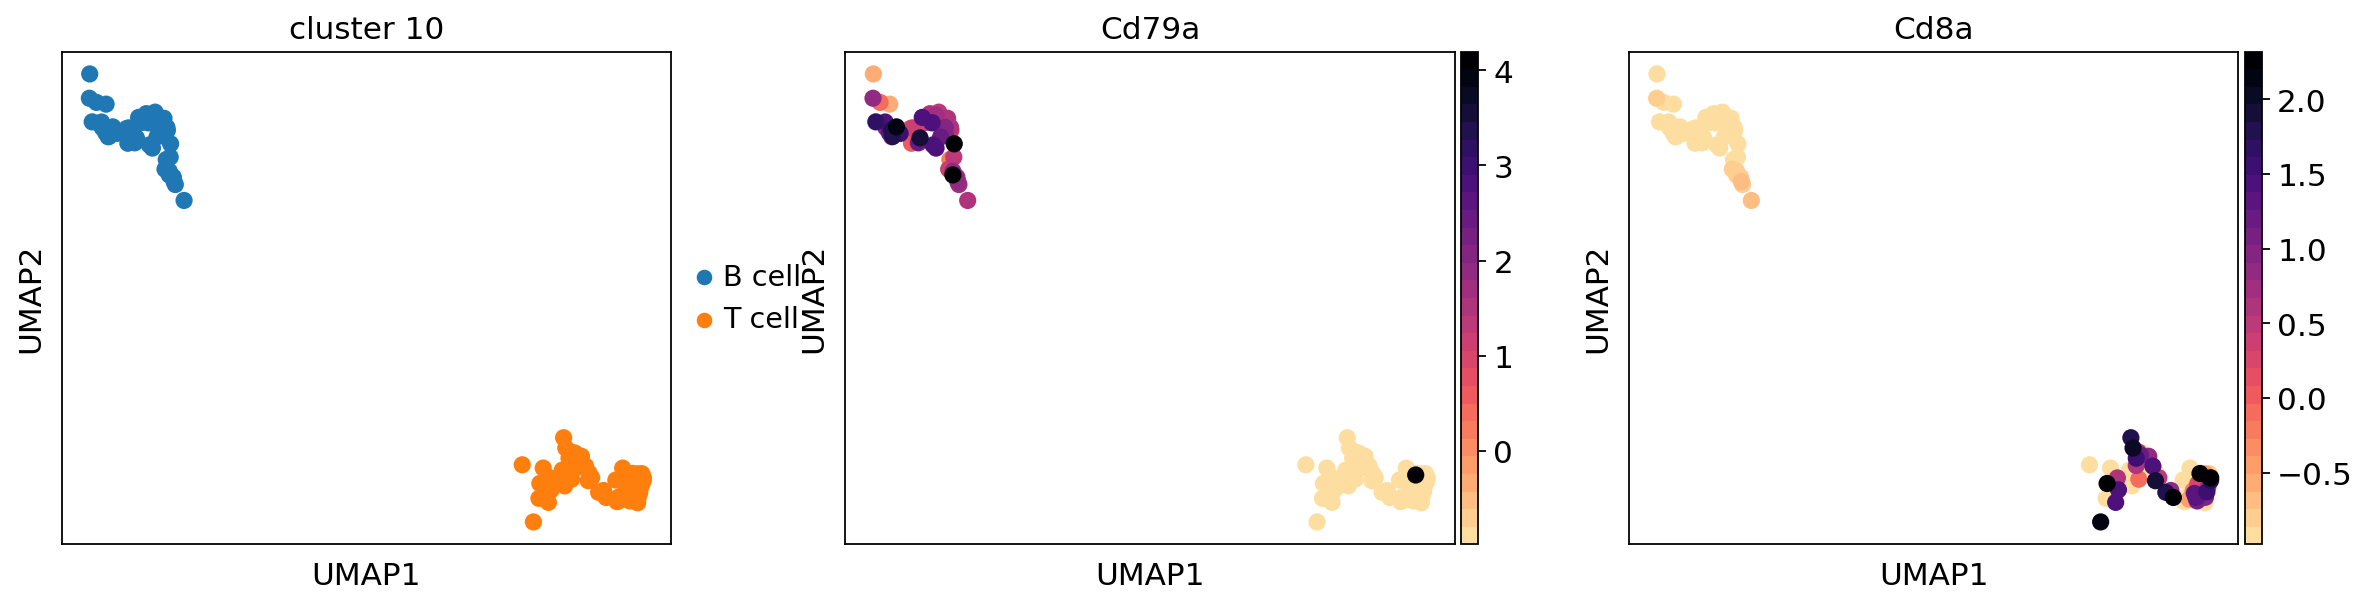

In [64]:
iel_cl10 = iel_only[iel_only.obs.leiden == "10",:]
sc.tl.leiden(iel_cl10, resolution=0.1 )
iel_cl10.obs["cluster 10"] = ["T cell" if cl == "0" else "B cell" for cl in iel_cl10.obs.leiden]
sc.pl.umap(iel_cl10, color=["cluster 10", "Cd79a", "Cd8a"], size=240, vmin="p2", vmax="p98", cmap=magma_cmap)

## <font color = "navy"> supplemental figure

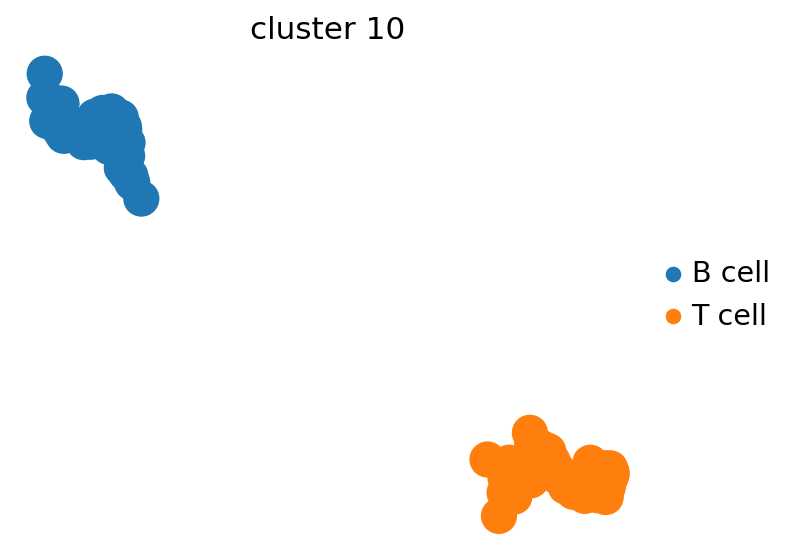

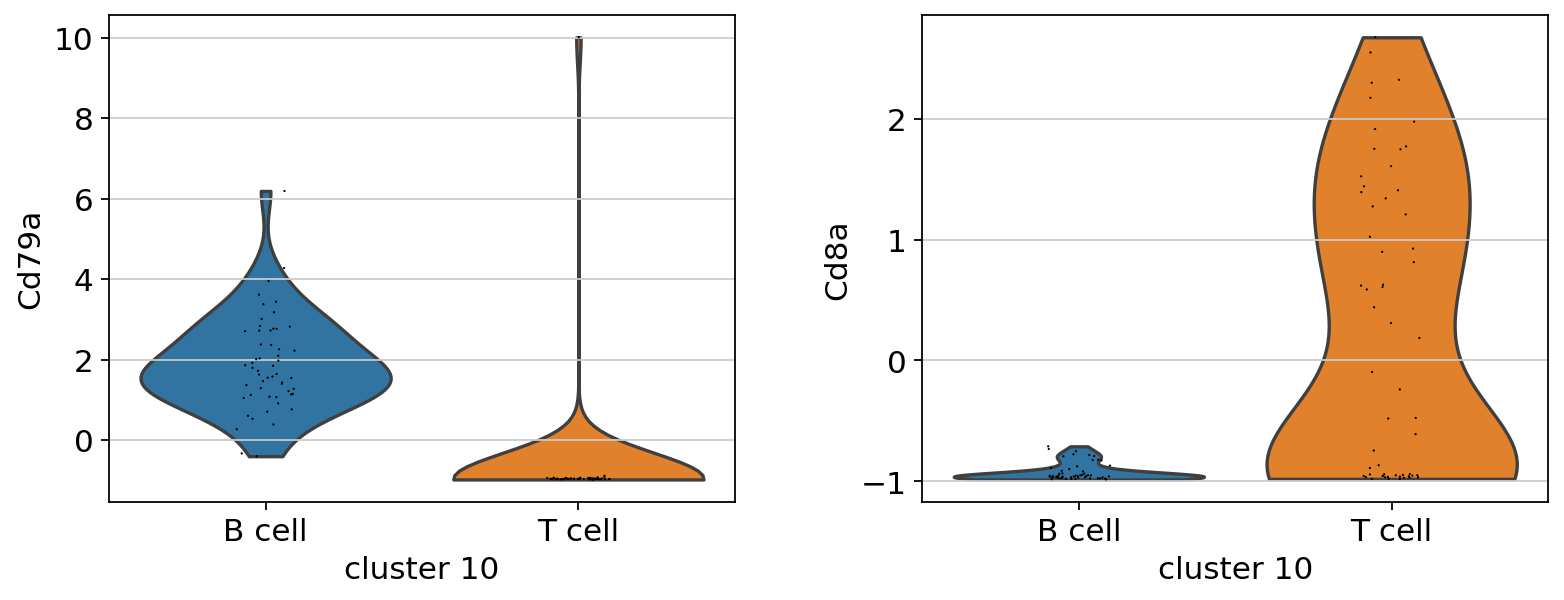

In [65]:
sc.pl.umap(iel_cl10, color=["cluster 10"], save="_cluster10.pdf", frameon=False)
sc.pl.violin(iel_cl10, keys=["Cd79a", "Cd8a"], groupby="cluster 10", save="_cluster10.pdf")

In [66]:
iel_cl10

AnnData object with n_obs × n_vars = 113 × 14332
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet', 'potential_doublet', 'sample', 'raw_biotin', 'cell_norm_biotin', 'sample_type', 'leiden', 'leiden ', 'normalized biotin', 'og normalized biotin', 'cluster 10'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'scrublet', 'pearson_residuals_normalization', 'pca', 'neighbors', 'leiden', 'umap', 'sample_colors', 'sample_type_colors', 'leiden_colors', 'cluster 10_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_counts', 'pearson_theta_1'
    obsp: 'distances', 'connectivities'

In [67]:
iel_only.obs.leiden = iel_only.obs.leiden.cat.add_categories(["10a", "10b"])

In [68]:
iel_only.obs.loc[iel_only.obs.leiden == "10","leiden"] = [
    "10a" if iel_cl10.obs.loc[cell]["leiden"] == "0" else 
    "10b" for cell in iel_only.obs_names[iel_only.obs.leiden == "10"]]

/Genomics/grid/users/skwalker/tcr_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.


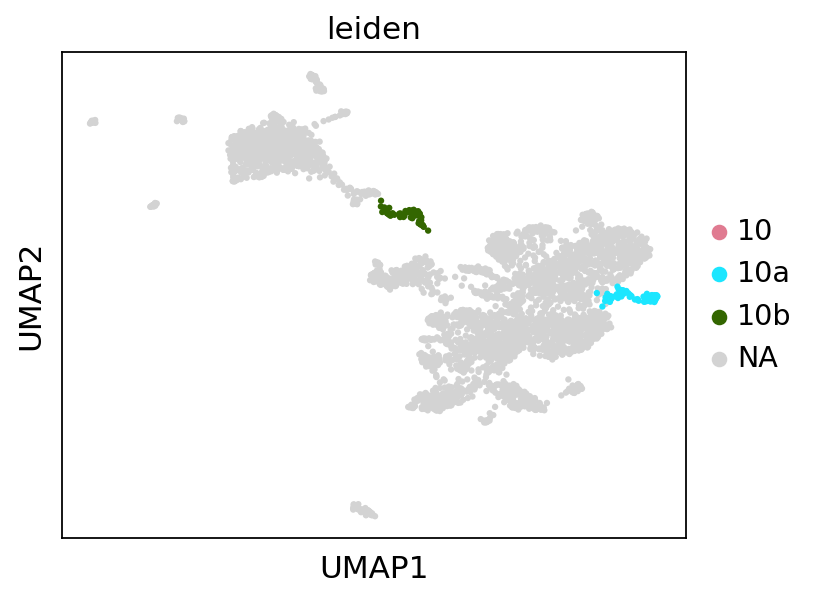

In [69]:
sc.pl.umap(iel_only, color="leiden", groups=["10", "10a", "10b"])

## annotate clusters with the correct cell types based on gene expression

## <font color = "navy"> supplemental figure

In [70]:
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

In [71]:
grayblue_cmap = LinearSegmentedColormap.from_list("n", colors=["lightgray", "darkblue"])

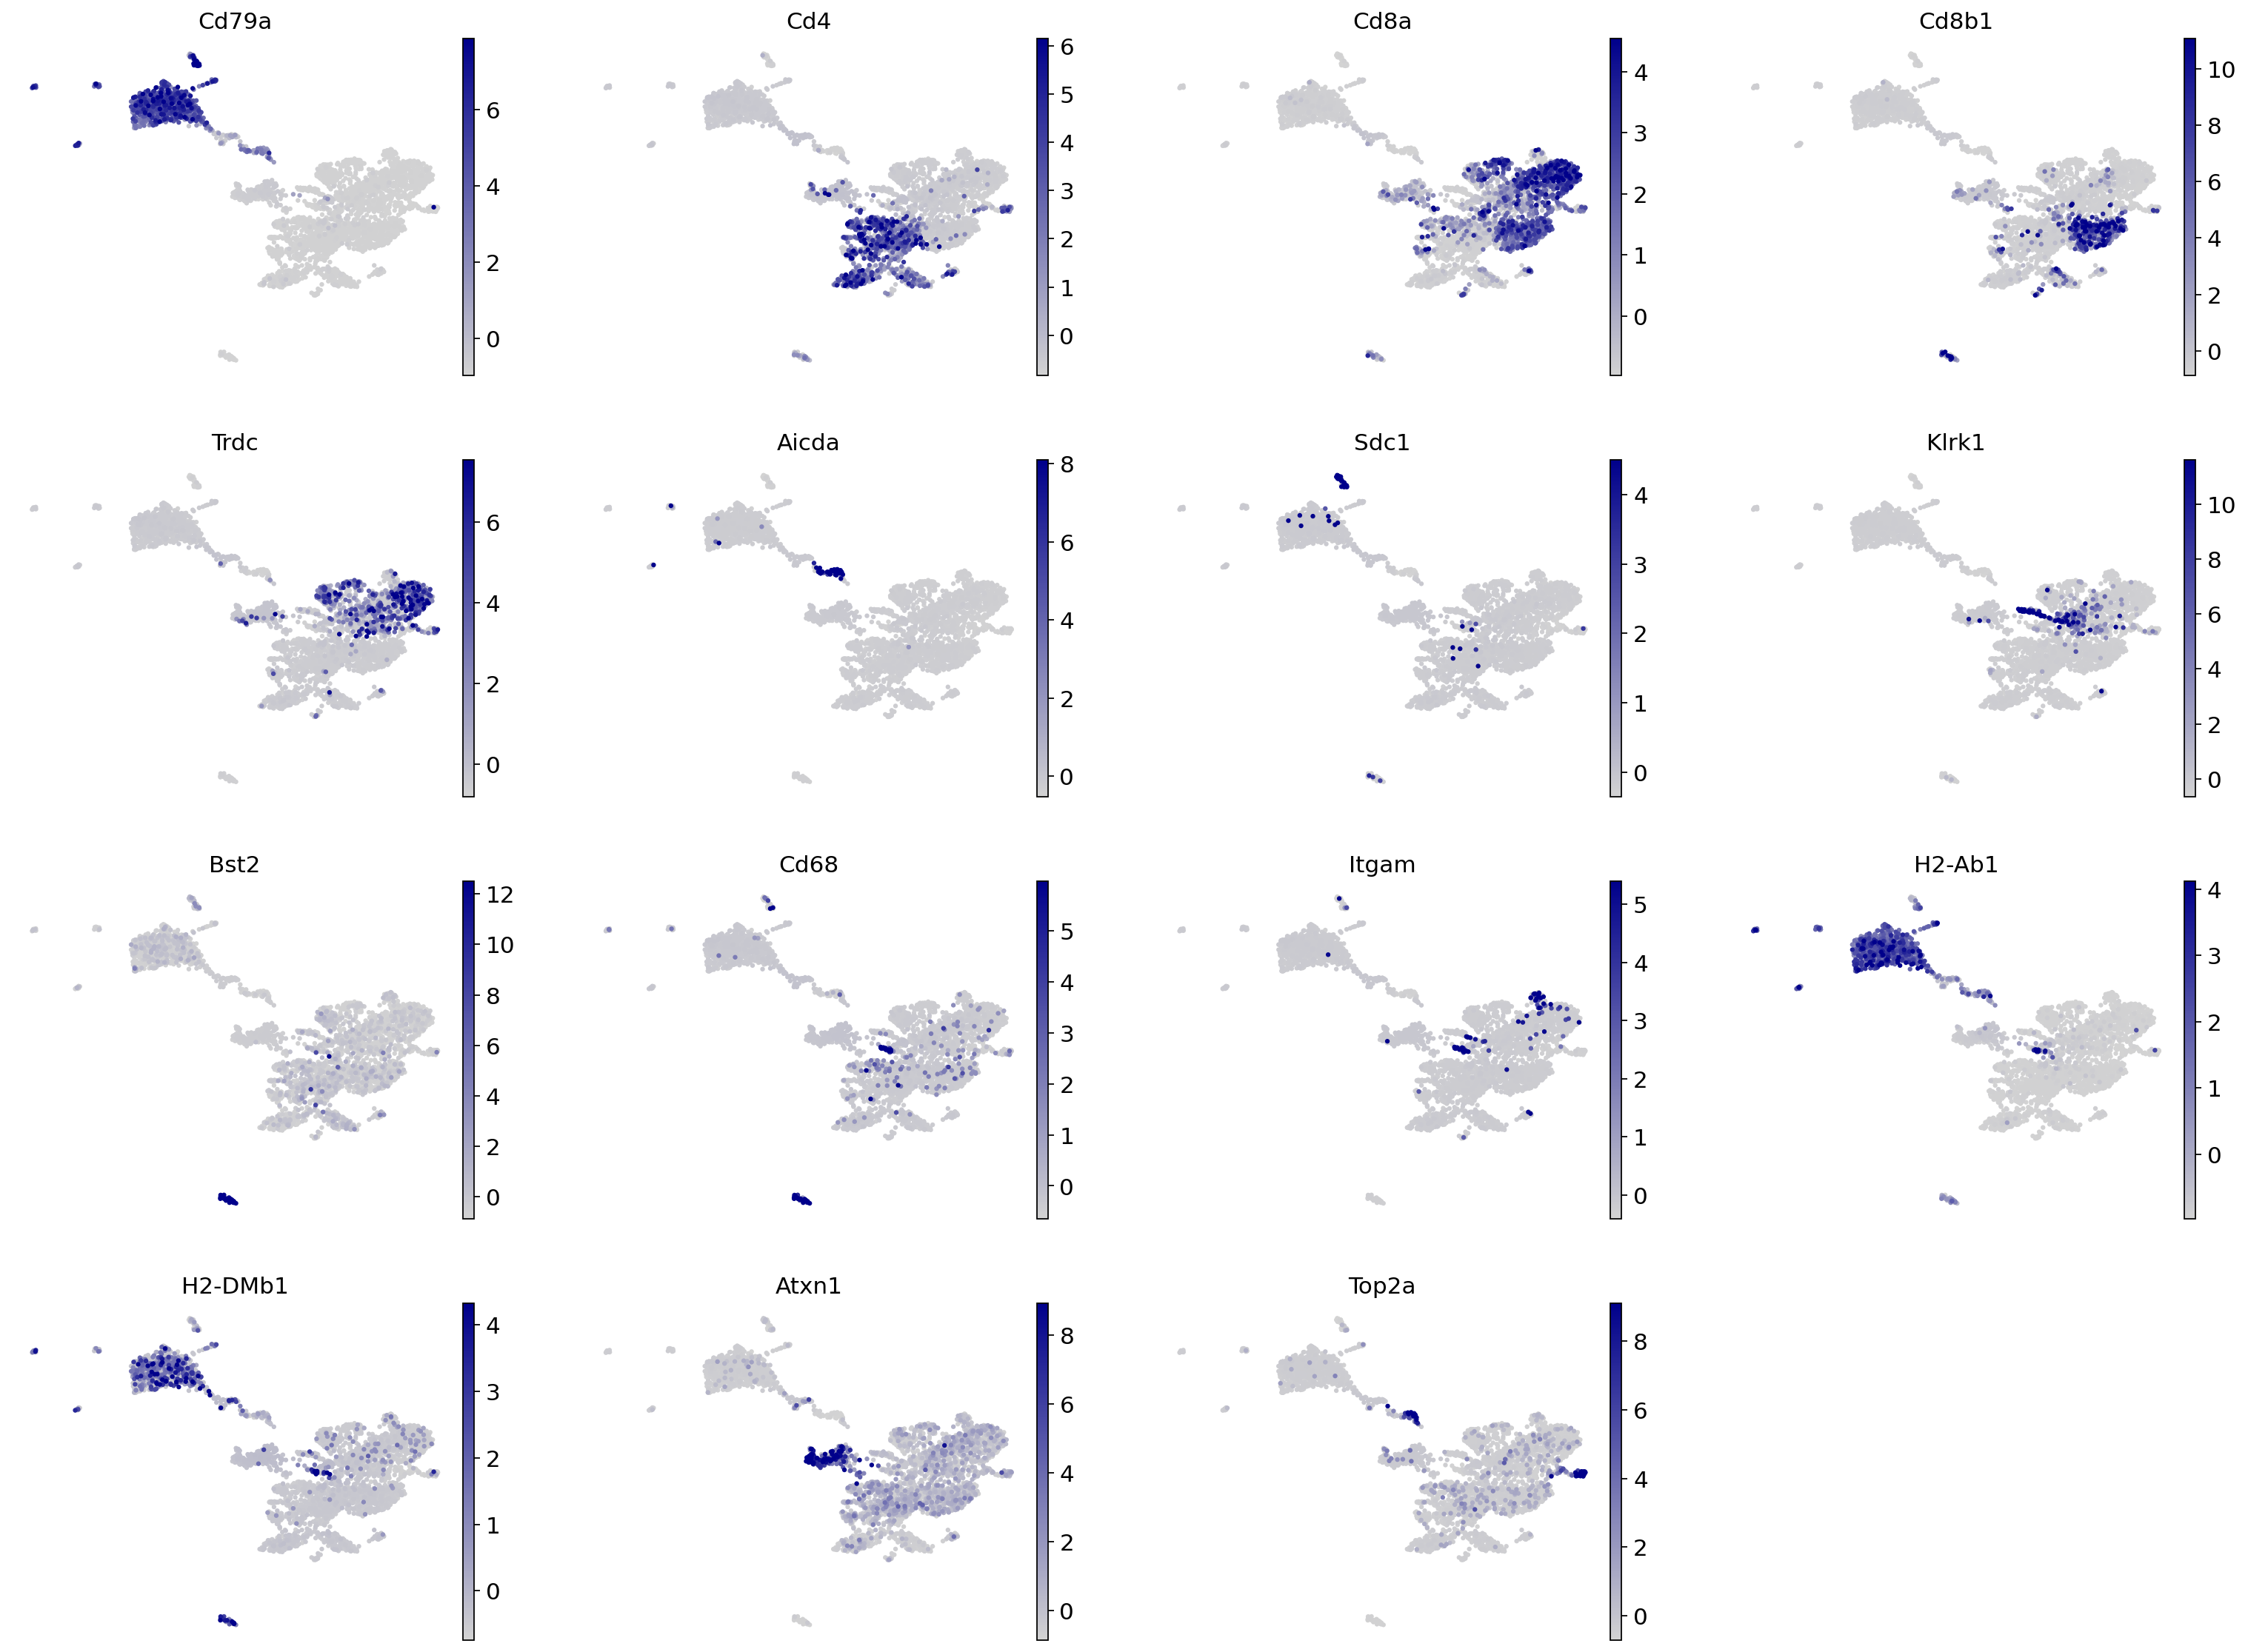

In [72]:
sc.pl.umap(iel_only, color =  ["Cd79a", ## B cells
                               "Cd4", ## Cd4 cells
                               "Cd8a", "Cd8b1", "Trdc", ## Cd8 vs Cd8 aa/GD cells: professional IEL 
                               "Aicda", ## GC B cell
                               "Sdc1", ## plasma B cell
                               "Klrk1", ## NK cell
                               "Bst2", ## pDC
                               "Cd68", "Itgam", "H2-Ab1", "H2-DMb1", ## small myeloid cluster
                               "Atxn1",  ## other cluster, expressing Atxn1
                               "Top2a" ## cycling (cluster 10)
                              ], layer="pearson_theta_1", vmin = "p1", vmax="p99", ncols = 4, 
           save="_gex.v1.pdf", frameon=False, cmap=grayblue_cmap)

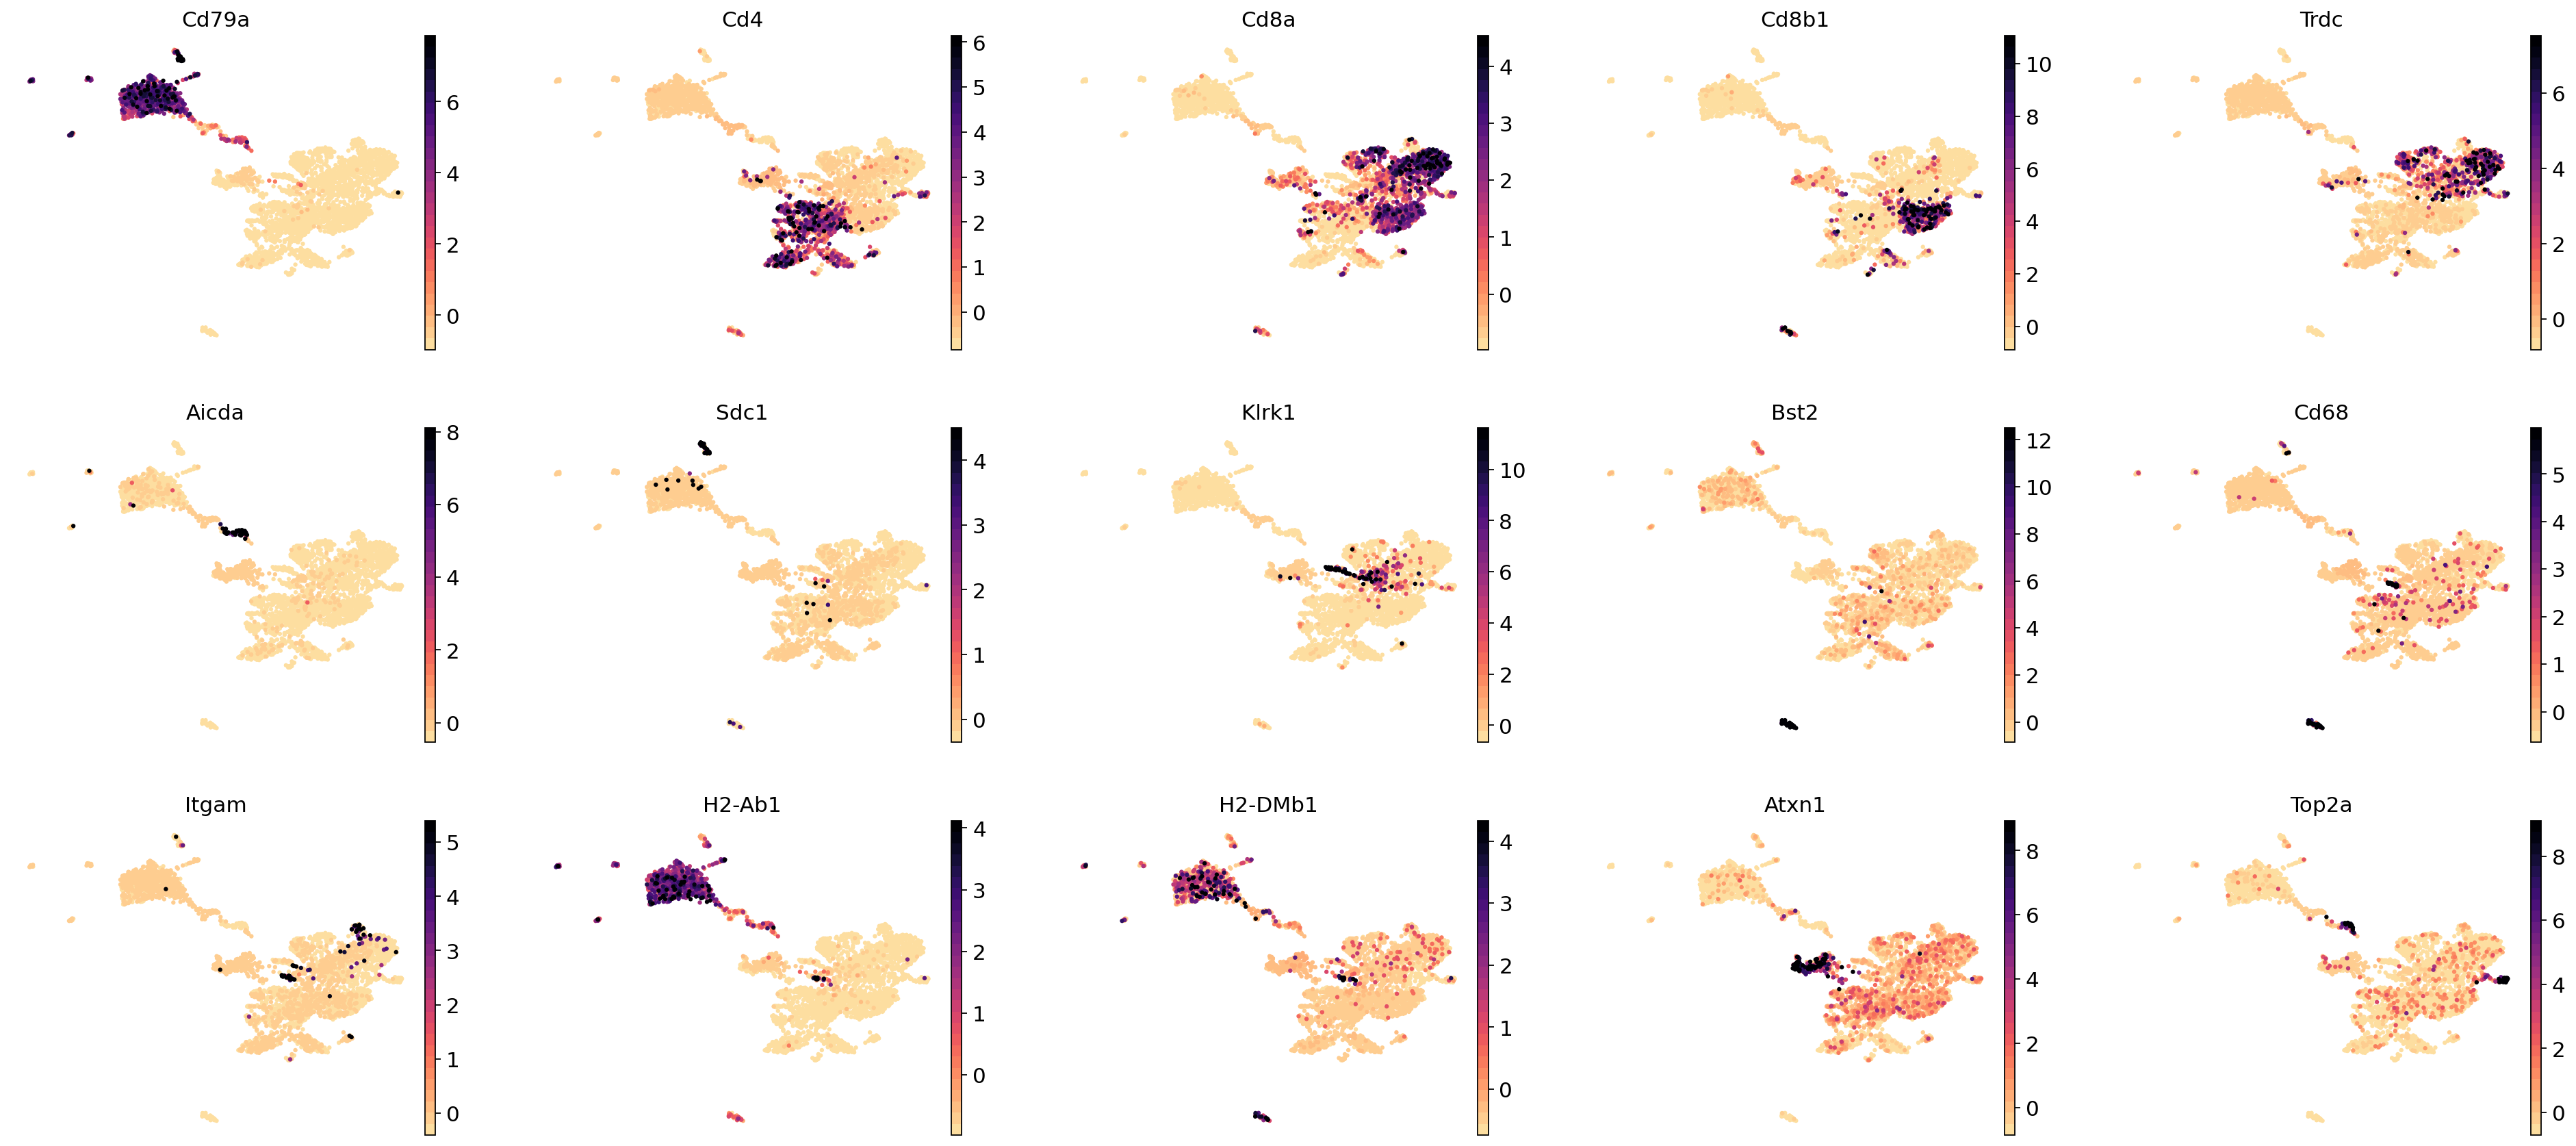

In [73]:
sc.pl.umap(iel_only, color =  ["Cd79a", ## B cells
                               "Cd4", ## Cd4 cells
                               "Cd8a", "Cd8b1", "Trdc", ## Cd8 vs Cd8 aa/GD cells: professional IEL 
                               "Aicda", ## GC B cell
                               "Sdc1", ## plasma B cell
                               "Klrk1", ## NK cell
                               "Bst2", ## pDC
                               "Cd68", "Itgam", "H2-Ab1", "H2-DMb1", ## small myeloid cluster
                               "Atxn1",  ## other cluster, expressing Atxn1
                               "Top2a" ## cycling (cluster 10)
                              ], layer="pearson_theta_1", vmin = "p1", vmax="p99", ncols = 5, save="_gex.v2.pdf",
          cmap=magma_cmap, frameon=False)

## confirm cell cycle signature in cycling cells (getting genes from Seurat)

In [74]:
g2m_genes = "HMGB2''CDK1''NUSAP1''UBE2C''BIRC5''TPX2''TOP2A''NDC80''CKS2''NUF2''CKS1B''MKI67''TMPO''CENPF''TACC3''FAM64A''SMC4''CCNB2''CKAP2L''CKAP2''AURKB''BUB1''KIF11''ANP32E''TUBB4B''GTSE1''KIF20B''HJURP''CDCA3''HN1''CDC20''TTK''CDC25C''KIF2C''RANGAP1''NCAPD2''DLGAP5''CDCA2''CDCA8''ECT2''KIF23''HMMR''AURKA''PSRC1''ANLN''LBR''CKAP5''CENPE''CTCF''NEK2''G2E3''GAS2L3''CBX5''CENPA".split("''")

In [75]:
s_genes = "MCM5''PCNA''TYMS''FEN1''MCM2''MCM4''RRM1''UNG''GINS2''MCM6''CDCA7''DTL''PRIM1''UHRF1''MLF1IP''HELLS''RFC2''RPA2''NASP''RAD51AP1''GMNN''WDR76''SLBP''CCNE2''UBR7''POLD3''MSH2''ATAD2''RAD51''RRM2''CDC45''CDC6''EXO1''TIPIN''DSCC1''BLM''CASP8AP2''USP1''CLSPN''POLA1''CHAF1B''BRIP1''E2F8".split("''")

In [76]:
sc.tl.score_genes_cell_cycle(iel_only, g2m_genes=list(pd.Series(g2m_genes).str.capitalize()),
                             s_genes = list(pd.Series(s_genes).str.capitalize()))

/Genomics/grid/users/skwalker/tcr_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/Genomics/grid/users/skwalker/tcr_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


In [77]:
iel_only.var_names[iel_only.var_names.str.startswith("Tcr")]

Index(['Tcrg-V7', 'Tcrg-V4', 'Tcrg-V6', 'Tcrg-V5', 'Tcrg-C1', 'Tcrg-V3',
       'Tcrg-C3', 'Tcrg-C2', 'Tcrg-V1', 'Tcrg-C4'],
      dtype='object')

## <font color = "navy"> supplemental figure

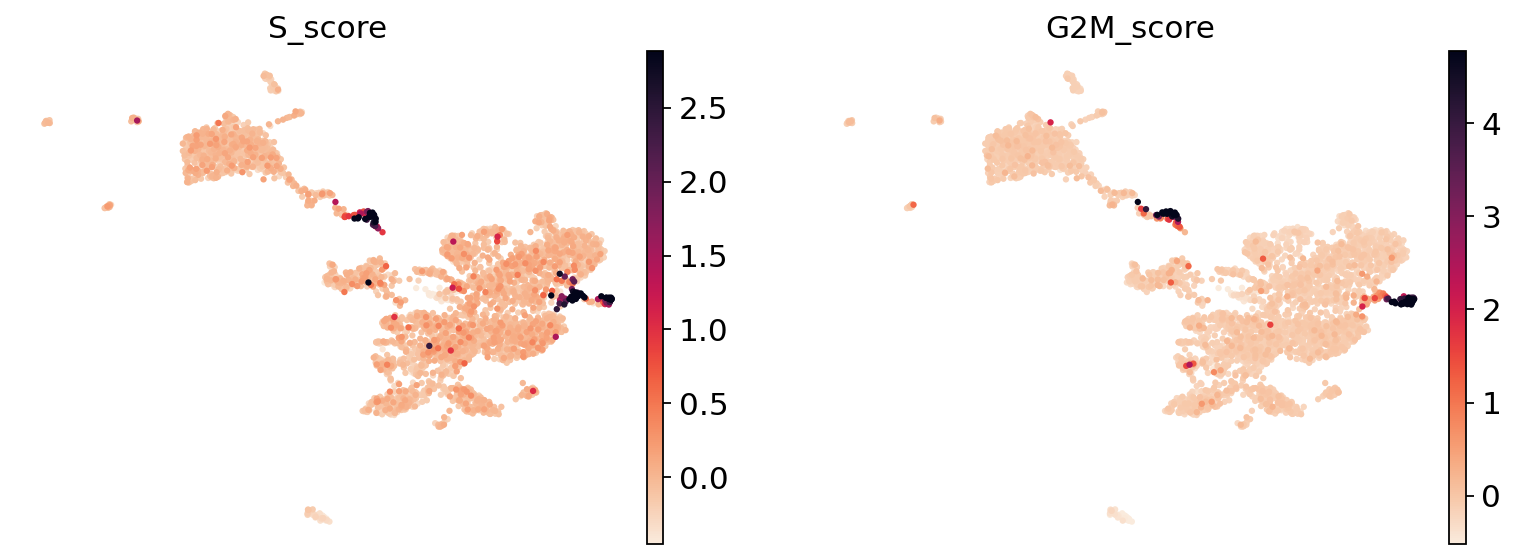

In [78]:
sc.pl.umap(iel_only, color = ["S_score", "G2M_score"],  save="_cellcycle.pdf", 
           cmap="rocket_r", frameon=False, vmin="p1", vmax = "p99")

## determine final annotations

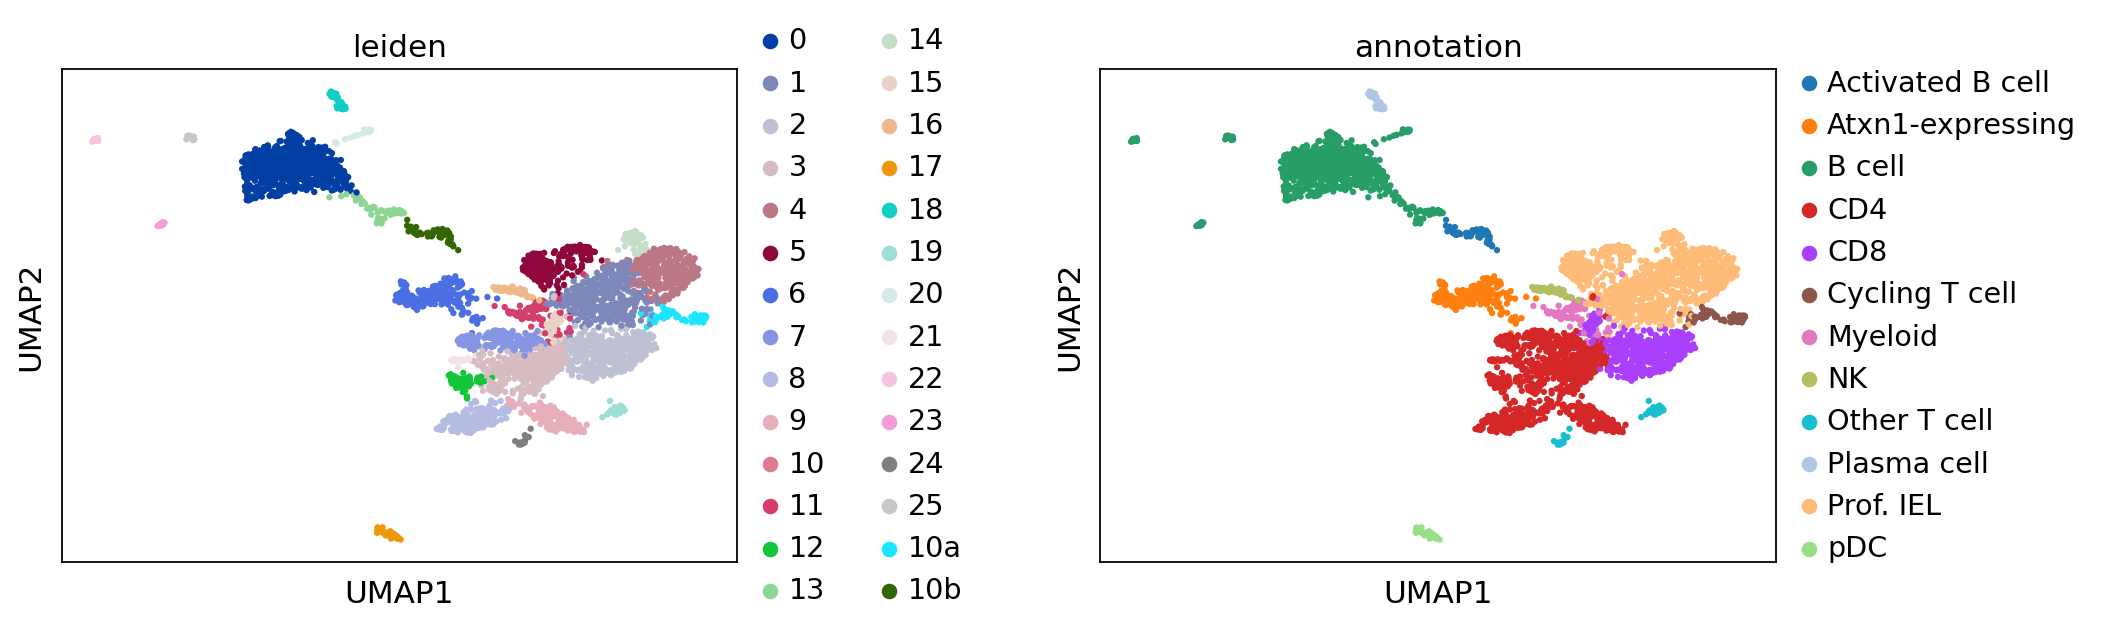

In [79]:
def annotate(cl):
    if cl == "10a":
        return "Cycling T cell"
    if cl == '10b':
        return "Activated B cell"
    cl = int(cl)
    if cl in [2, 15]:
        return "CD8"
    if cl in [3, 7, 8, 9, 12, 21]:
        return "CD4"
    if cl in [4, 5, 14, 1]:
        return "Prof. IEL"
    if cl in [0, 13, 20, 22, 23, 25]:
        return "B cell"
    if cl == 18:
        return "Plasma cell"
    if cl == 16:
        return "NK"
    if cl == 17:
        return "pDC"
    if cl == 6:
        return "Atxn1-expressing"
    if cl == 11:
        return "Myeloid"
    else:
        return "Other T cell"
iel_only.obs["annotation"] = [ annotate(cl) for cl in iel_only.obs["leiden"]]
sc.pl.umap(iel_only, color=["leiden", "annotation"], wspace= 0.4)

In [80]:
iel_only.obs["annotation "] = iel_only.obs["annotation"].str.replace("-", "-\n") 

In [81]:
sc.set_figure_params(figsize=(7,6), vector_friendly=False)

## <font color = "purple"> main figure, SC panel 1

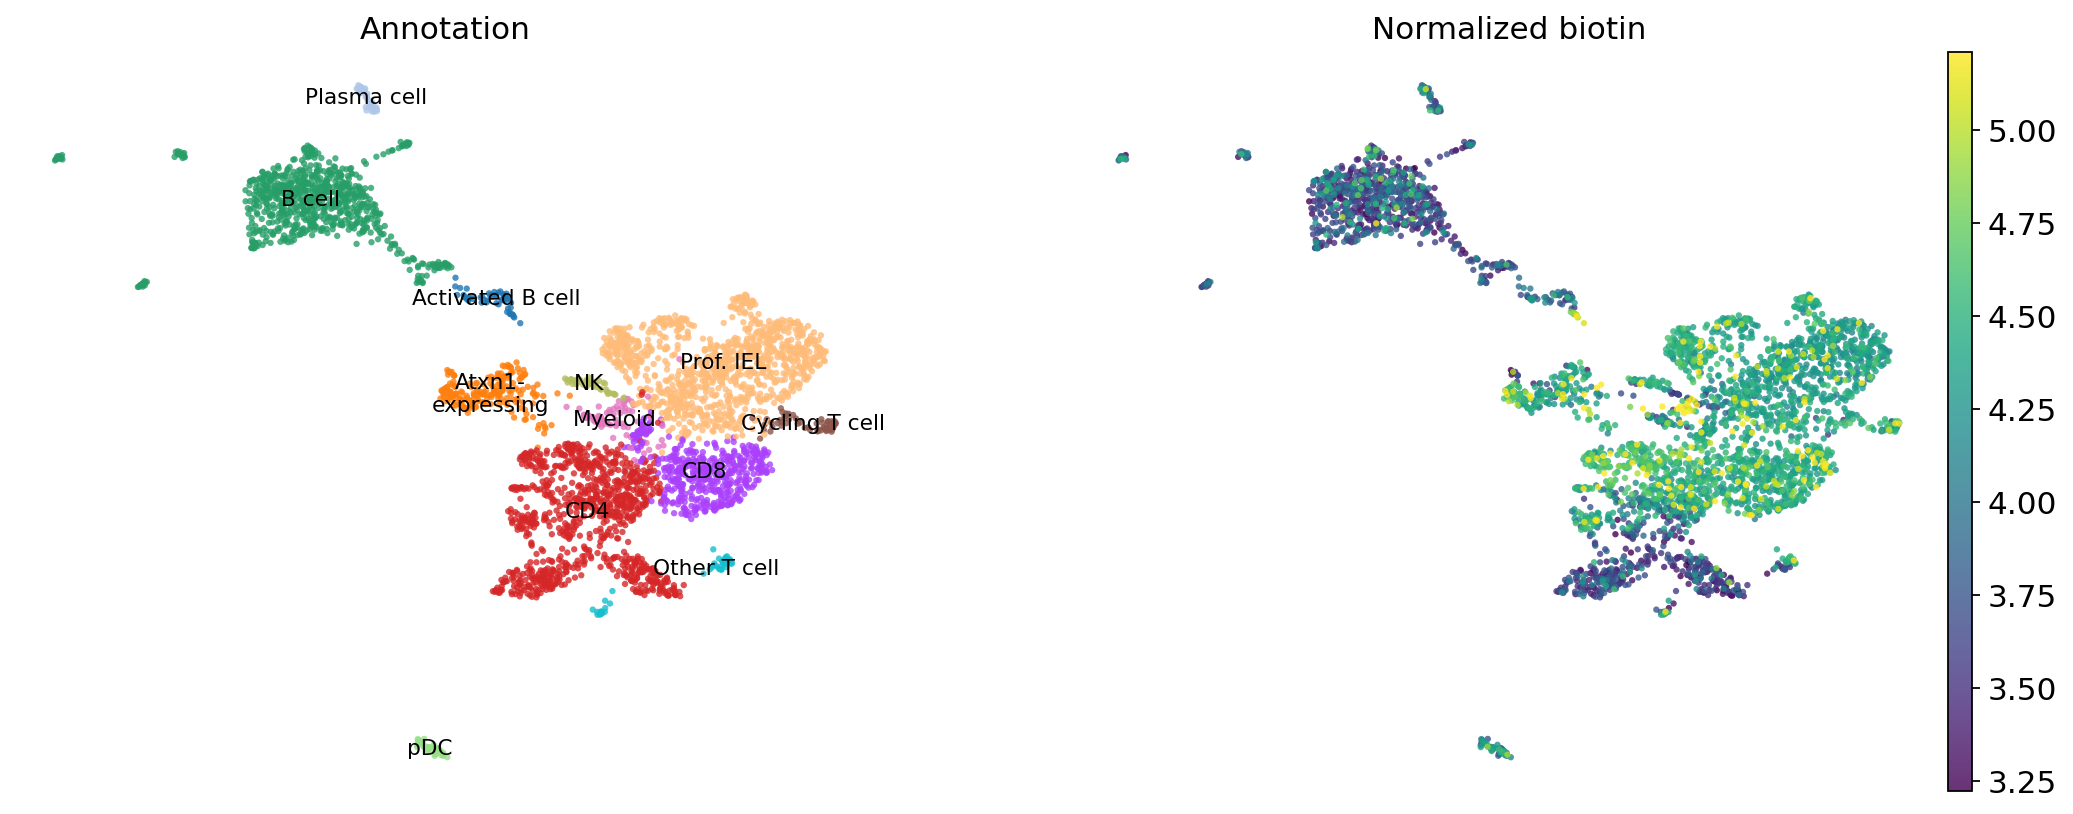

In [82]:
sc.settings.figdir="paper_figures/"
sc.pl.umap(iel_only, color=["annotation ", "normalized biotin"], 
           legend_loc = 'on data', legend_fontsize = "x-small", legend_fontweight="medium",
          vmin="p2", vmax="p98", alpha=0.8,  color_map = "viridis", save="_panel_1.pdf", frameon=False,
          title = ["Annotation", "Normalized biotin"])

## <font color = "navy"> supplemental figure

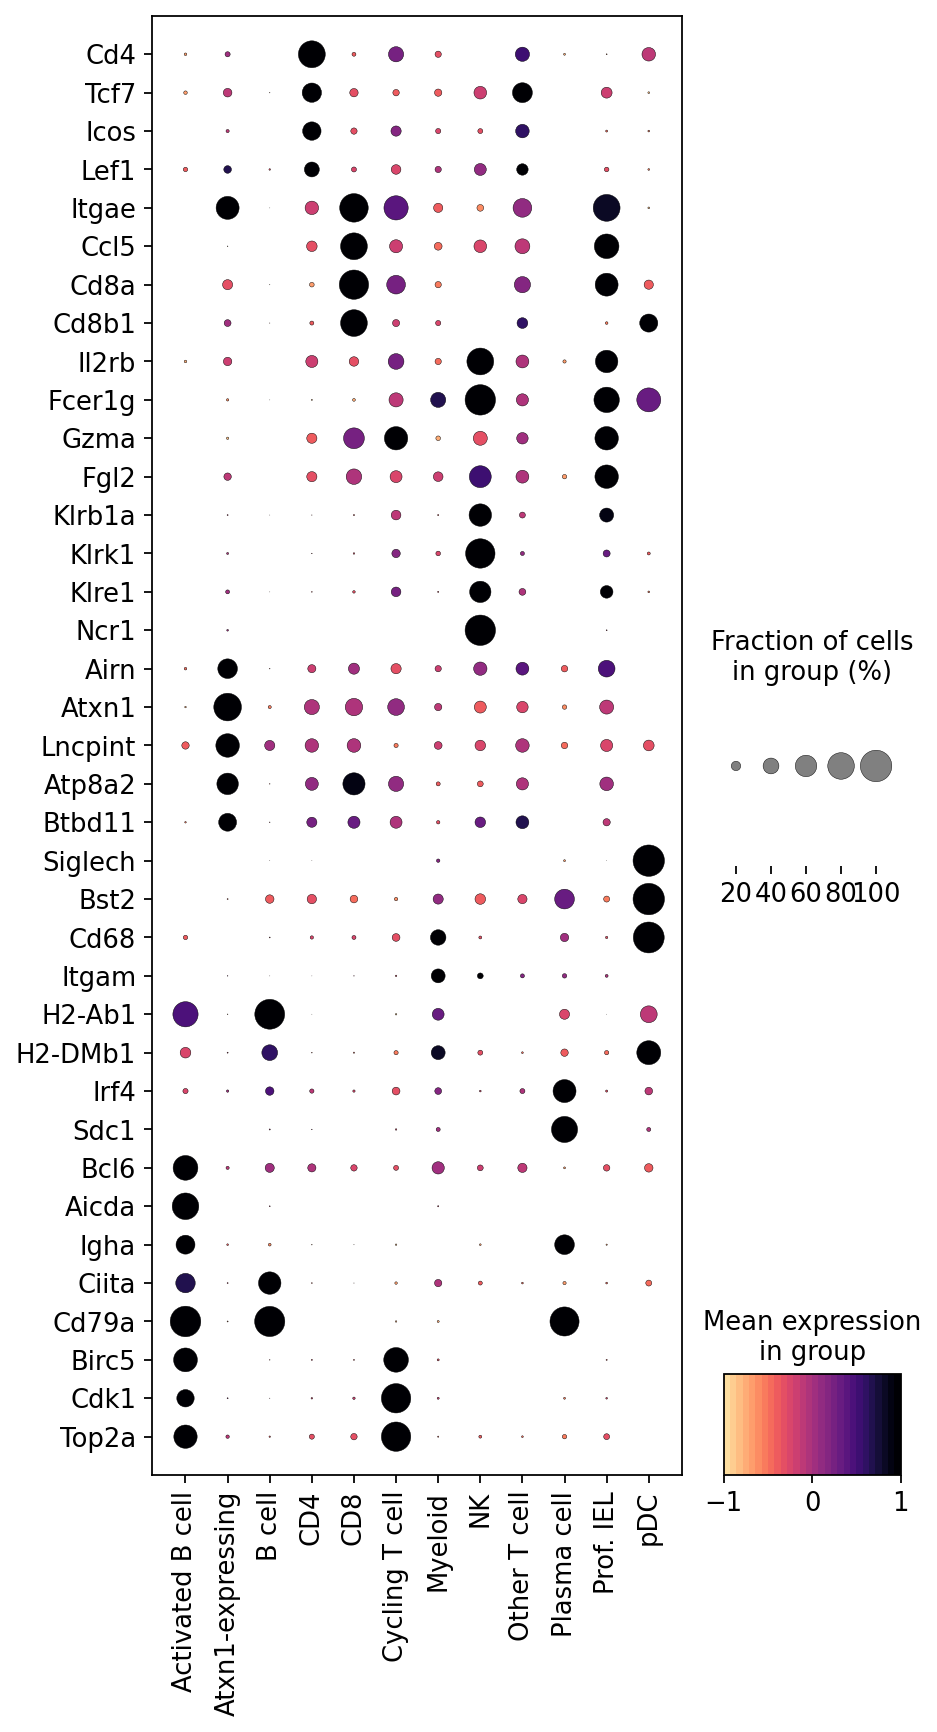

In [83]:
sc.settings.figdir="paper_figures/supplemental/"
sc.pl.dotplot(iel_only, groupby="annotation", 
                     var_names = ["Cd4", "Tcf7", "Icos", "Lef1", # Cd4 T cells
                                  "Itgae", "Ccl5",  "Cd8a", "Cd8b1", # Cd8 T cells 
                                  "Il2rb", "Fcer1g", "Gzma", "Fgl2", ## GD T cells
                                  "Klrb1a", "Klrk1", "Klre1", "Ncr1", # NK cells
                                  "Airn", "Atxn1", "Lncpint", "Atp8a2", "Btbd11", # other, Atxn1-expressing
                                  "Siglech", "Bst2","Cd68",  # pDC
                                  "Itgam", "H2-Ab1", "H2-DMb1", # myeloid population
                                  "Irf4", "Sdc1", "Bcl6", "Aicda", "Igha", "Ciita", "Cd79a",  # B cell populations
                                  "Birc5", "Cdk1", "Top2a" # cycling cell populations
                     ],
                     norm = mpl.colors.Normalize(vmin=-1, vmax=1), cmap = magma_cmap, swap_axes=True, 
                     layer="pearson_theta_1", figsize=(6, 12), save="gex_annotation.pdf")

In [84]:
sc.set_figure_params(figsize=(5,6), vector_friendly=False)

## <font color = "navy"> also include in supplement?

In [85]:
leiden_cats = pd.api.types.CategoricalDtype(categories = np.array([ str(x) for x in range(10)] + ["10a", "10b"] + 
                                                                 [ str(x) for x in range(11,26)]), ordered = True)
iel_only.obs[" leiden "] = iel_only.obs["leiden"].astype(leiden_cats)

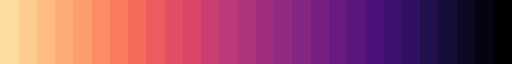

In [86]:
magma_cmap

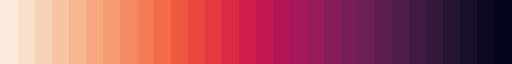

In [87]:
rocket_cmap = mpl.colors.ListedColormap(mpl.cm.get_cmap("rocket_r")(np.linspace(0,1,30)))
rocket_cmap

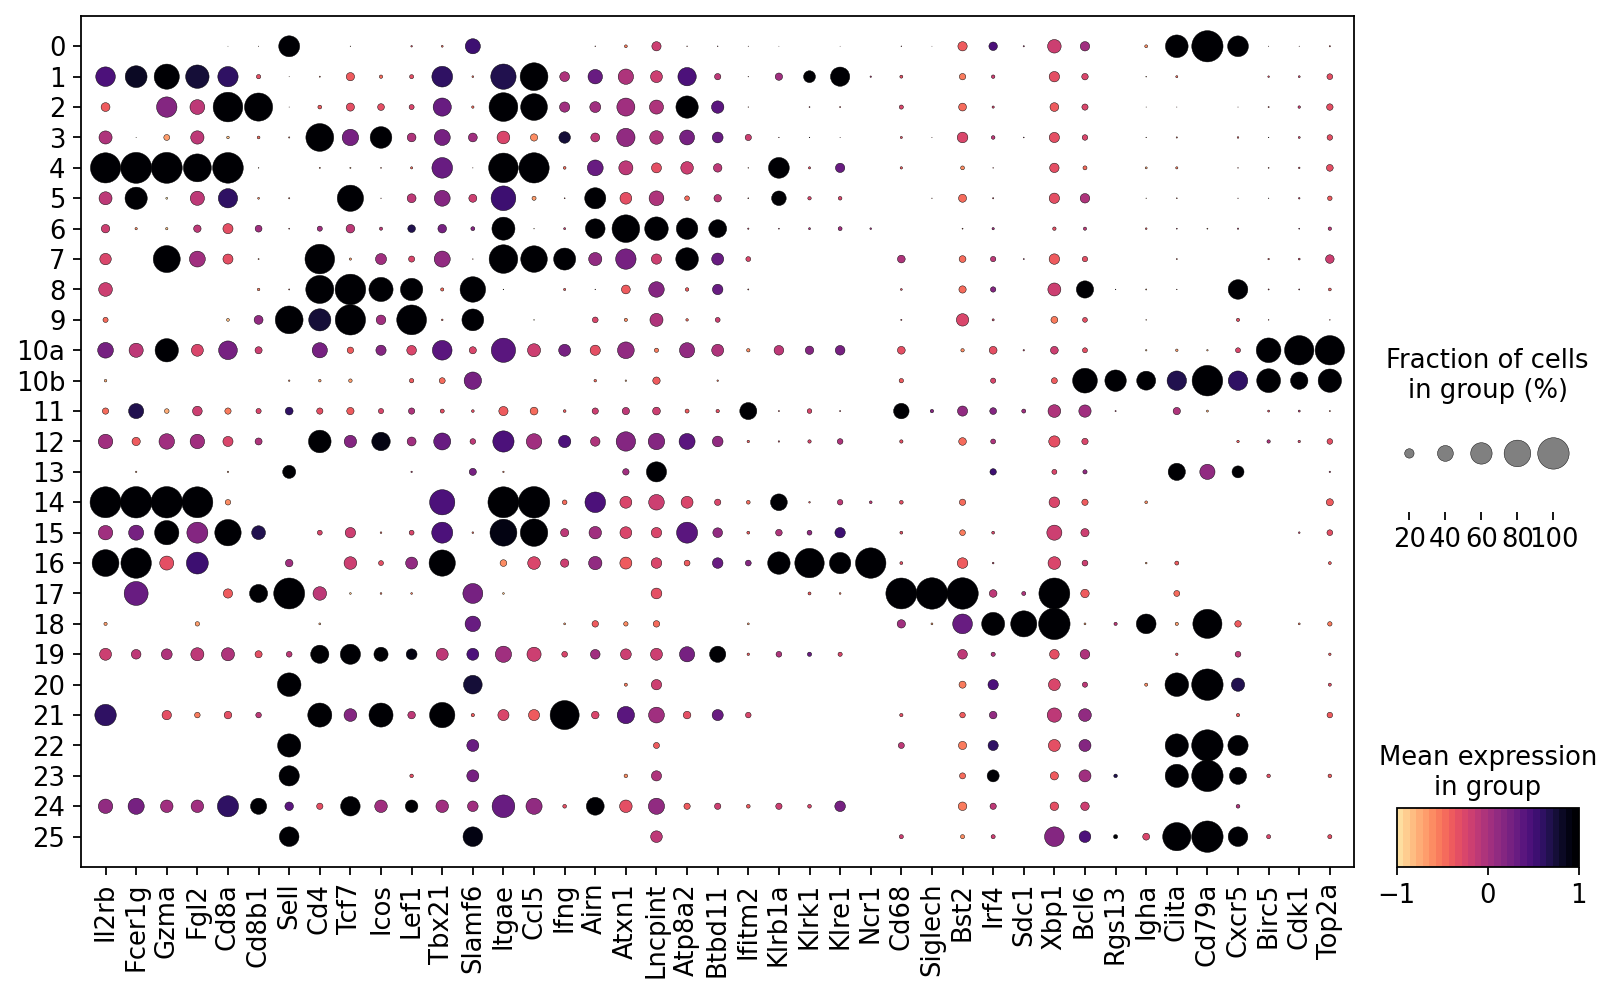

In [88]:
sc.pl.dotplot(iel_only, groupby=" leiden ", 
                     var_names = ["Il2rb", "Fcer1g", "Gzma", "Fgl2", "Cd8a", "Cd8b1", "Sell",
                                  "Cd4", "Tcf7", "Icos", "Lef1", "Tbx21", "Slamf6",
                                  "Itgae", "Ccl5",  "Ifng",
                                  "Airn", "Atxn1", "Lncpint", "Atp8a2", "Btbd11",
                                  "Ifitm2", "Klrb1a", "Klrk1", "Klre1", "Ncr1",
                                  "Cd68", "Siglech",  "Bst2",
                                  "Irf4", "Sdc1","Xbp1", "Bcl6", "Rgs13", "Igha", "Ciita", "Cd79a", 
                                  "Cxcr5", "Birc5", "Cdk1", "Top2a",
                     ],
                     norm = mpl.colors.Normalize(vmin=-1, vmax=1), cmap=magma_cmap, swap_axes=False, 
                     layer="pearson_theta_1", figsize=(12, 7),  save="gex_cluster.pdf")

## using panglaodb scores for immune cell subsets to confirm annotations

This file was downloaded from https://panglaodb.se/markers.html?cell_type=%27choose%27 using all cell markers, and was then filtered for Immune system.

In [89]:
panglaodb = pd.read_csv("immune_panglaodb.tsv", sep = "\t", header=None)
print(panglaodb.shape)
panglaodb = panglaodb[panglaodb[0].str.contains("Mm")]
print(panglaodb.shape)
panglaodb.head()

(1682, 14)
(1516, 14)


0      1        2                 3      4   \
0  Mm Hs    CD2  B cells               NaN  0.040   
1  Mm Hs    CD5  B cells               NaN  0.004   
2  Mm Hs  MS4A1  B cells   Bp35|MS4A2|CD20  0.014   
3  Mm Hs    CR2  B cells         CD21|C3DR  0.001   
4  Mm Hs   CD22  B cells  SIGLEC-2|SIGLEC2  0.003   

                               5                    6    7         8   \
0                    CD2 molecule  protein-coding gene  NaN  Mesoderm   
1                    CD5 molecule  protein-coding gene  1.0  Mesoderm   
2  membrane spanning 4-domains A1  protein-coding gene  1.0  Mesoderm   
3       complement C3d receptor 2  protein-coding gene  1.0  Mesoderm   
4                   CD22 molecule  protein-coding gene  1.0  Mesoderm   

              9         10        11        12        13  
0  Immune system  0.000000  0.213178  0.095847  0.026554  
1  Immune system  0.000000  0.000000  0.004153  0.004502  
2  Immune system  0.483871  0.620155  0.011182  0.001566  
3  Immune system  0.048387  0.034884  0.000000  0.000000  
4  Immune system  0.096774  0.127907  0.001278  0.000196

In [90]:
panglaodb["gene"] = panglaodb[1].str.capitalize()
panglaodb["cell type"] = panglaodb[2]
panglaodb.head()

0      1        2                 3      4  \
0  Mm Hs    CD2  B cells               NaN  0.040   
1  Mm Hs    CD5  B cells               NaN  0.004   
2  Mm Hs  MS4A1  B cells   Bp35|MS4A2|CD20  0.014   
3  Mm Hs    CR2  B cells         CD21|C3DR  0.001   
4  Mm Hs   CD22  B cells  SIGLEC-2|SIGLEC2  0.003   

                                5                    6    7         8  \
0                    CD2 molecule  protein-coding gene  NaN  Mesoderm   
1                    CD5 molecule  protein-coding gene  1.0  Mesoderm   
2  membrane spanning 4-domains A1  protein-coding gene  1.0  Mesoderm   
3       complement C3d receptor 2  protein-coding gene  1.0  Mesoderm   
4                   CD22 molecule  protein-coding gene  1.0  Mesoderm   

               9        10        11        12        13   gene cell type  
0  Immune system  0.000000  0.213178  0.095847  0.026554    Cd2   B cells  
1  Immune system  0.000000  0.000000  0.004153  0.004502    Cd5   B cells  
2  Immune system  0.483871  0.620155  0.011182  0.001566  Ms4a1   B cells  
3  Immune system  0.048387  0.034884  0.000000  0.000000    Cr2   B cells  
4  Immune system  0.096774  0.127907  0.001278  0.000196   Cd22   B cells

In [91]:
adata_copy = iel_only.copy()
for ct in np.unique(panglaodb["cell type"]):
    sc.tl.score_genes(adata_copy, gene_list=list(panglaodb[panglaodb["cell type"] == ct]["gene"].unique()),
                      score_name=ct)

/Genomics/grid/users/skwalker/tcr_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


/Genomics/grid/users/skwalker/tcr_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


/Genomics/grid/users/skwalker/tcr_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


/Genomics/grid/users/skwalker/tcr_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


/Genomics/grid/users/skwalker/tcr_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


/Genomics/grid/users/skwalker/tcr_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


/Genomics/grid/users/skwalker/tcr_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


/Genomics/grid/users/skwalker/tcr_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


/Genomics/grid/users/skwalker/tcr_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


/Genomics/grid/users/skwalker/tcr_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


/Genomics/grid/users/skwalker/tcr_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


/Genomics/grid/users/skwalker/tcr_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


/Genomics/grid/users/skwalker/tcr_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


/Genomics/grid/users/skwalker/tcr_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


/Genomics/grid/users/skwalker/tcr_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


/Genomics/grid/users/skwalker/tcr_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


/Genomics/grid/users/skwalker/tcr_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


/Genomics/grid/users/skwalker/tcr_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


/Genomics/grid/users/skwalker/tcr_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/Genomics/grid/users/skwalker/tcr_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/Genomics/grid/users/skwalker/tcr_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


/Genomics/grid/users/skwalker/tcr_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


/Genomics/grid/users/skwalker/tcr_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


/Genomics/grid/users/skwalker/tcr_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/Genomics/grid/users/skwalker/tcr_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


## <font color = "navy"> supplemental figure

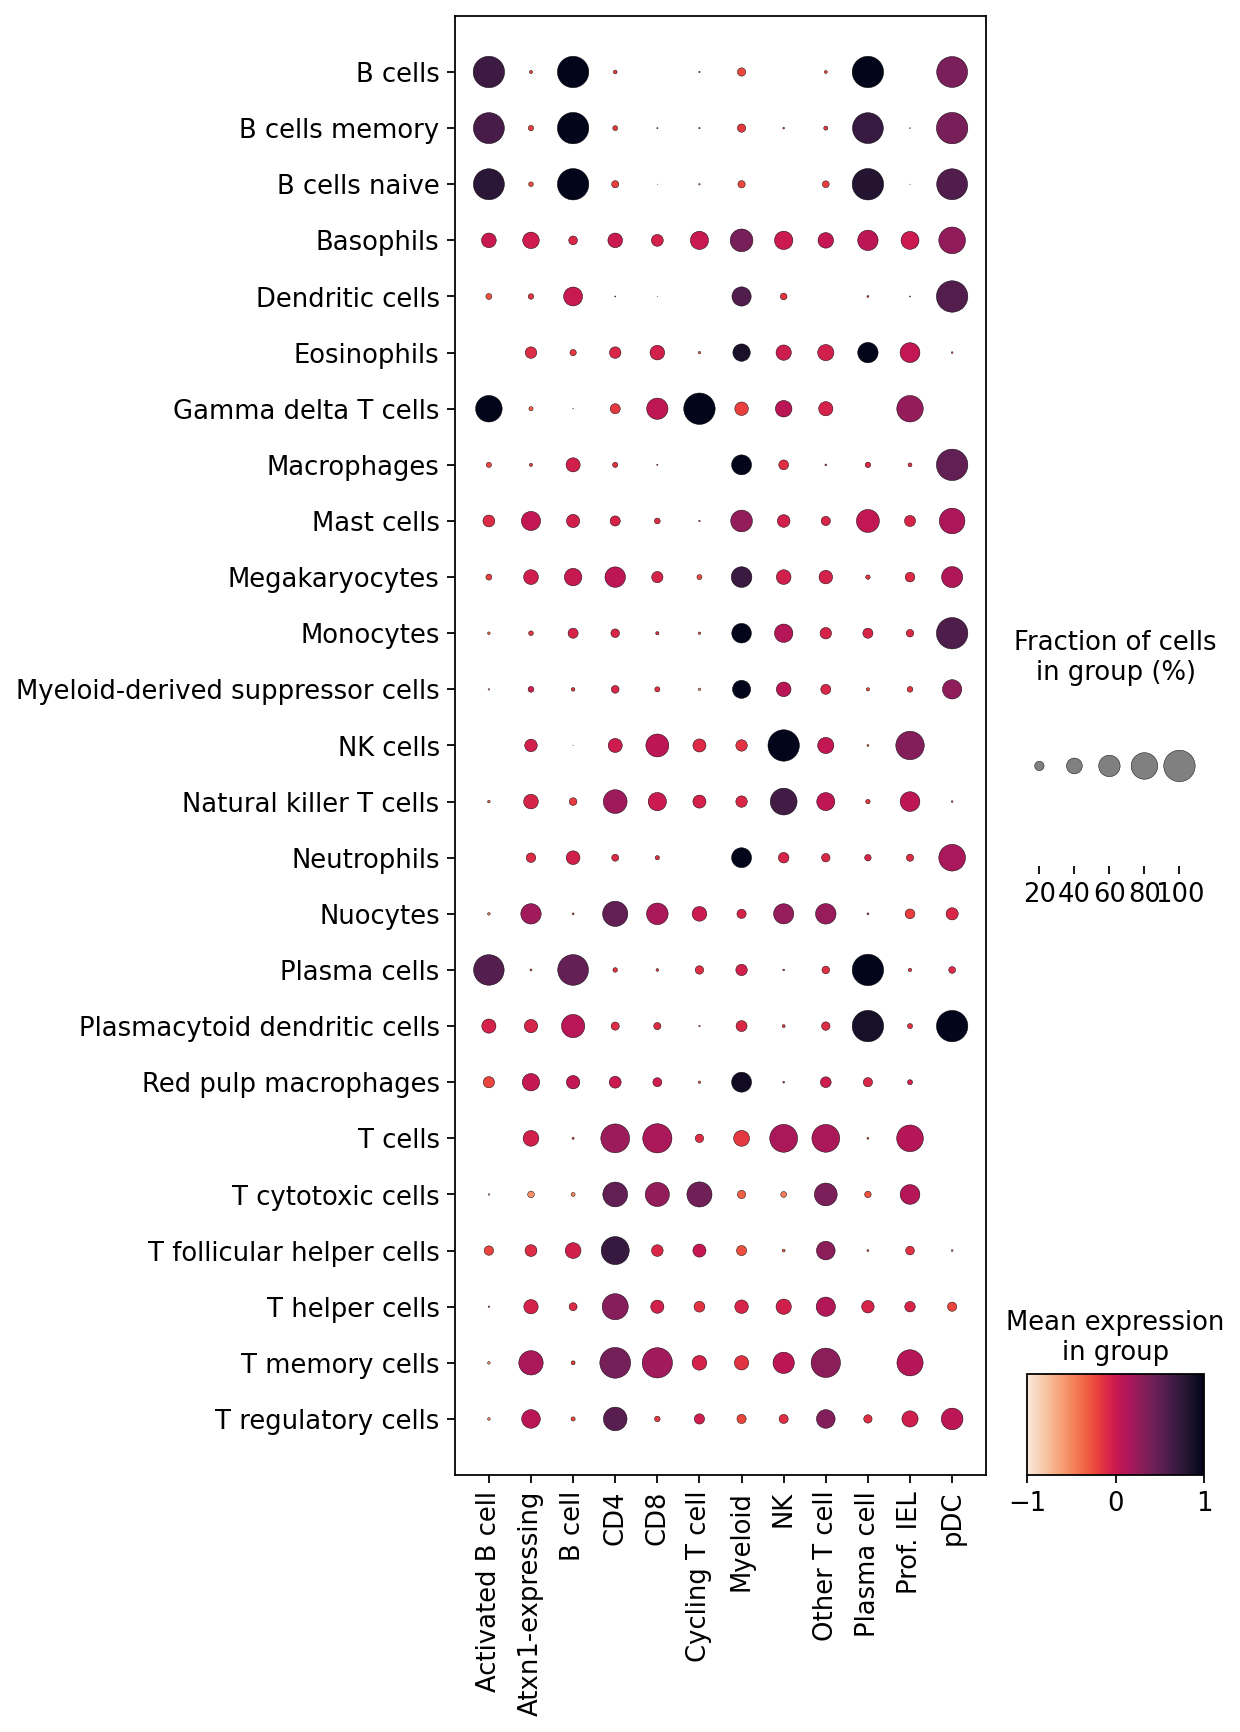

In [92]:
sc.pl.dotplot(adata_copy, var_names = np.unique(panglaodb["cell type"]), groupby="annotation", 
             norm = mpl.colors.Normalize(vmin=-1, vmax=1), swap_axes = True,  cmap="rocket_r",
              save="panglaodb_annot.pdf", figsize=(6, 12))

## cluster together based on DEGs: helps us figure out which clusters are more similar and should be grouped together

In [93]:
iel_only.layers

Layers with keys: raw_counts, pearson_theta_1

In [94]:
degs_cl = make_lfcs(iel_only, "raw_counts", "pearson_theta_1", cl_level = "leiden")

0.0029915692284703255
0


/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  results: log2FC > 0.5: 1478 genes; log2FC < -0.5: 901 genes
1


/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  results: log2FC > 0.5: 163 genes; log2FC < -0.5: 679 genes
10a


/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  results: log2FC > 0.5: 1238 genes; log2FC < -0.5: 1830 genes
10b


/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  results: log2FC > 0.5: 1060 genes; log2FC < -0.5: 1429 genes
11


/Genomics/grid/users/skwalker/tcr_env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:279: RuntimeWarning: divide by zero encountered in log
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:19: RuntimeWarning: divide by zero encountered in true_divide
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:19: RuntimeWarning: invalid value encountered in true_divide
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pand

  results: log2FC > 0.5: 531 genes; log2FC < -0.5: 117 genes
12


/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  results: log2FC > 0.5: 16 genes; log2FC < -0.5: 1 genes
13


/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  results: log2FC > 0.5: 1621 genes; log2FC < -0.5: 834 genes
14


/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  results: log2FC > 0.5: 901 genes; log2FC < -0.5: 1383 genes
15


/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  results: log2FC > 0.5: 27 genes; log2FC < -0.5: 2 genes
16


/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  results: log2FC > 0.5: 71 genes; log2FC < -0.5: 16 genes
17


/Genomics/grid/users/skwalker/tcr_env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:279: RuntimeWarning: divide by zero encountered in log
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:19: RuntimeWarning: divide by zero encountered in true_divide
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:19: RuntimeWarning: invalid value encountered in true_divide
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pand

  results: log2FC > 0.5: 1319 genes; log2FC < -0.5: 1891 genes
18


/Genomics/grid/users/skwalker/tcr_env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:279: RuntimeWarning: divide by zero encountered in log
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:19: RuntimeWarning: divide by zero encountered in true_divide
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:19: RuntimeWarning: invalid value encountered in true_divide
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pand

  results: log2FC > 0.5: 1336 genes; log2FC < -0.5: 2217 genes
19


/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  results: log2FC > 0.5: 1 genes; log2FC < -0.5: 0 genes
2


/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  results: log2FC > 0.5: 170 genes; log2FC < -0.5: 694 genes
20


/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  results: log2FC > 0.5: 148 genes; log2FC < -0.5: 18 genes
21


/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  results: log2FC > 0.5: 62 genes; log2FC < -0.5: 11 genes
22


/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  results: log2FC > 0.5: 96 genes; log2FC < -0.5: 10 genes
23


/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  results: log2FC > 0.5: 75 genes; log2FC < -0.5: 15 genes
24


/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  results: log2FC > 0.5: 1 genes; log2FC < -0.5: 0 genes
25


/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  results: log2FC > 0.5: 51 genes; log2FC < -0.5: 9 genes
3


/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  results: log2FC > 0.5: 157 genes; log2FC < -0.5: 307 genes
4


/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  results: log2FC > 0.5: 879 genes; log2FC < -0.5: 1018 genes
5


/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  results: log2FC > 0.5: 463 genes; log2FC < -0.5: 792 genes
6


/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  results: log2FC > 0.5: 1927 genes; log2FC < -0.5: 1431 genes
7


/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  results: log2FC > 0.5: 221 genes; log2FC < -0.5: 829 genes
8


/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  results: log2FC > 0.5: 871 genes; log2FC < -0.5: 109 genes
9
  results: log2FC > 0.5: 280 genes; log2FC < -0.5: 357 genes


/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


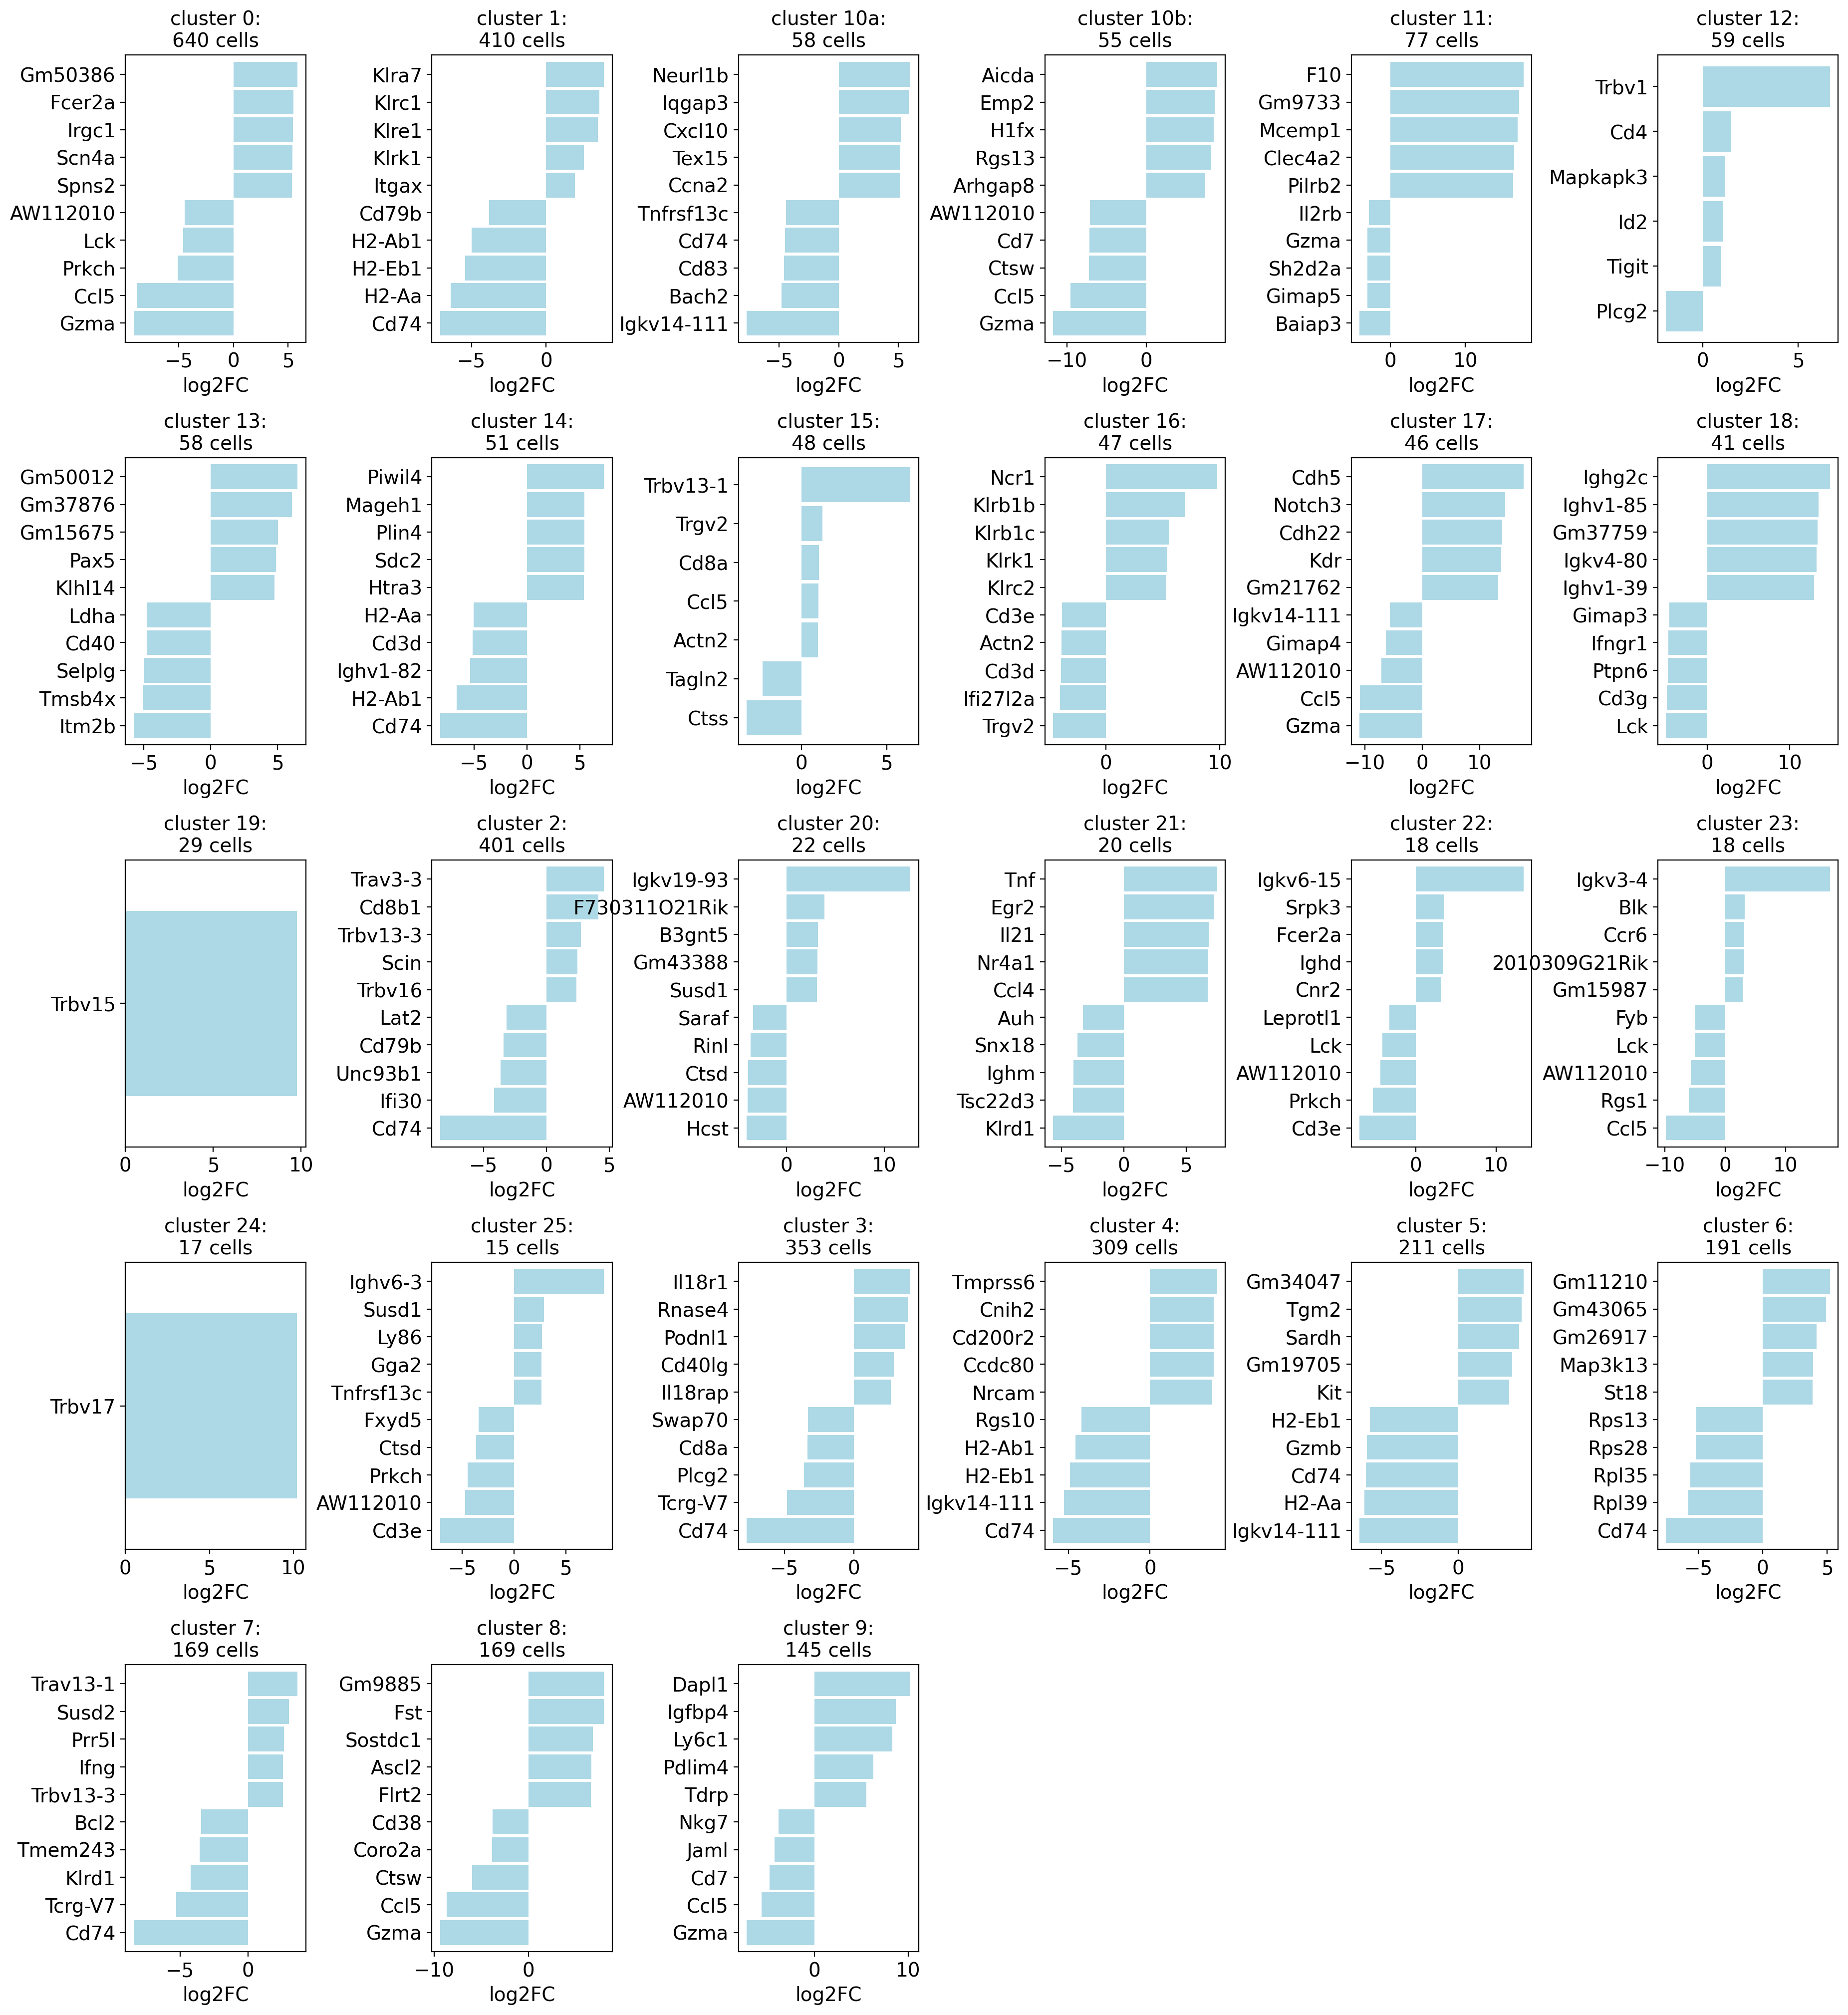

In [95]:
plot_diff_expr(degs_cl[(degs_cl["padj"] <= 0.05) & (abs(degs_cl["log2FC"]) > 0.5)],
               iel_only, cl_name= "leiden", top_n = 5, figsize=(22, 25), wspace = 0.7, hspace = 0.4, nrows=5)

In [ ]:
degs_cl[]

In [96]:
write_lfc_spreadsheet(degs_cl, "supplementary_tables/leiden_cluster_degs.xls")

/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:76: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.


In [103]:
degs_annot = make_lfcs(iel_only, "raw_counts", "pearson_theta_1", cl_level = "annotation")

0.0029915692284703255
Activated B cell


/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  results: log2FC > 0.5: 1060 genes; log2FC < -0.5: 1429 genes
Atxn1-expressing


/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  results: log2FC > 0.5: 1927 genes; log2FC < -0.5: 1431 genes
B cell


/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  results: log2FC > 0.5: 1482 genes; log2FC < -0.5: 930 genes
CD4


/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  results: log2FC > 0.5: 235 genes; log2FC < -0.5: 510 genes
CD8


/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  results: log2FC > 0.5: 171 genes; log2FC < -0.5: 731 genes
Cycling T cell


/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  results: log2FC > 0.5: 1238 genes; log2FC < -0.5: 1830 genes
Myeloid


/Genomics/grid/users/skwalker/tcr_env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:279: RuntimeWarning: divide by zero encountered in log
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:19: RuntimeWarning: divide by zero encountered in true_divide
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:19: RuntimeWarning: invalid value encountered in true_divide
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pand

  results: log2FC > 0.5: 531 genes; log2FC < -0.5: 117 genes
NK


/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  results: log2FC > 0.5: 71 genes; log2FC < -0.5: 16 genes
Other T cell


/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  results: log2FC > 0.5: 4 genes; log2FC < -0.5: 0 genes
Plasma cell


/Genomics/grid/users/skwalker/tcr_env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:279: RuntimeWarning: divide by zero encountered in log
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:19: RuntimeWarning: divide by zero encountered in true_divide
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:19: RuntimeWarning: invalid value encountered in true_divide
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pand

  results: log2FC > 0.5: 1336 genes; log2FC < -0.5: 2217 genes
Prof. IEL


/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


  results: log2FC > 0.5: 837 genes; log2FC < -0.5: 879 genes
pDC


/Genomics/grid/users/skwalker/tcr_env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:279: RuntimeWarning: divide by zero encountered in log
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:19: RuntimeWarning: divide by zero encountered in true_divide
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:19: RuntimeWarning: invalid value encountered in true_divide


  results: log2FC > 0.5: 1319 genes; log2FC < -0.5: 1891 genes


/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [ ]:
write_lfc_spreadsheet(degs_cl, "supplementary_tables/leiden_cluster_degs.xls")

## supplementary figure 

In [ ]:
sc.settings.figdir="paper_figures/supplemental/"
sc.set_figure_params(figsize=(5, 4), vector_friendly=False)
iel_only.obs["cluster"] = [cl if "10" not in cl else "10" for cl in iel_only.obs["leiden"]]
sc.pl.umap(iel_only, color=[" leiden "], save="_cluster.pdf", frameon=False)

## <font color = "purple"> main figure 3, SC panel 2
   

## Reorder labels
- How about plasma cells, B cells, GC, pro IEL, CD8, CD4, cycling T, other T, NK, myeloid, PDC, atxn1

In [ ]:
iel_only.obs[" annotation "] = iel_only.obs["annotation"].astype(pd.api.types.CategoricalDtype(
    categories = ["plasma B cell", "B cell", "GC-like B cell", "professional IEL", "CD8", "CD4", "cycling T cell",
                 "other T cell", "NK", "myeloid", "pDC", "Atxn1-expressing"], ordered = True))


In [ ]:
sc.set_figure_params(figsize=(8, 5), vector_friendly=False)
ax = sc.pl.violin(iel_only, groupby=" annotation ", keys = "normalized biotin", rotation=90, ax = None, show = False)
ax.grid(False)
ax.axhline(norm_biotinpos_threshold, color = "black", linestyle="dotted")
plt.xlabel("Annotation")
plt.ylabel("Normalized biotin")
plt.savefig("paper_figures/violin_panel_2.pdf",  bbox_inches='tight')
sc.set_figure_params(figsize=(5,4), vector_friendly=False)

## <font color = "navy"> supplemental figure

In [ ]:
sc.set_figure_params(figsize=(8, 5), vector_friendly=False)
ax = sc.pl.violin(iel_only, groupby=" leiden ", keys = "normalized biotin", rotation=90, ax = None, show = False)
ax.grid(False)
ax.axhline(norm_biotinpos_threshold, color = "black", linestyle="dotted")
plt.savefig("paper_figures/supplemental/violin_biotin_cluster.pdf")
sc.set_figure_params(figsize=(5,4), vector_friendly=False)

In [ ]:
degs = make_lfcs(iel_only, "raw_counts", "pearson_theta_1", cl_level = "leiden")

## <font color="navy"> supplemental figure

In [ ]:
# separate T cell group cluster 19 seems related to CD4 clusters 8 and 9
make_dendrogram(np.unique(degs[(degs["padj"] <= 0.05) & (degs["log2FC"] >= 1)].sort_values(
    "log2FC", ascending=False)["gene"]), iel_only,  out_name="paper_figures/supplemental/iel.dendrogram.pdf")

## add in TCR

In [ ]:
adata = iel_only.copy()

In [ ]:
ir.__version__

In [ ]:
ir_ad

In [ ]:
ir_ad = ir.io.read_10x_vdj("/Genomics/pritykinlab/share/uLIPSTIC/data/cr_outputs/gut_vdj/outs/" + 
                        "filtered_contig_annotations.csv")
ir.tl.chain_qc(ir_ad)
ir.pp.merge_with_ir(adata, ir_ad)
adata

In [ ]:
sc.pl.umap(adata, color="chain_pairing")

## confirm that certain cell types have TCR and others don't

## <font color = "navy"> include in supplement as table?

In [ ]:
(adata.obs[~adata.obs["chain_pairing"].isna()].groupby("annotation").count()[["leiden"]]/adata.obs.groupby(
    "annotation").count()[["leiden"]]).rename(columns = {"leiden": "have VDJ data"}).reset_index().round(3)

In [ ]:
testing_clonotype_data = pd.read_csv("/Genomics/pritykinlab/share/uLIPSTIC/data/cr_outputs/gut_vdj/outs/" + 
                        "filtered_contig_annotations.csv").set_index("barcode")
testing_clonotype_data.head()

In [ ]:
testing_clonotype_data.shape

In [ ]:
np.sum(~adata.obs["IR_VJ_2_junction"].isna())

In [ ]:
adata.obs[adata.obs.columns[adata.obs.columns.str.contains("call")]]

In [ ]:
adata.obs[adata.obs.columns[adata.obs.columns.str.contains("junction")]]

In [ ]:
clono_inter = np.intersect1d(adata.obs_names, testing_clonotype_data.index)

In [ ]:
len(clono_inter)

In [ ]:
len(testing_clonotype_data.loc[clono_inter].raw_clonotype_id.unique())

In [ ]:
len(adata.obs.clone_id.unique())

In [ ]:
np.sum(~adata.obs["chain_pairing"].isna())

In [ ]:
ir.pp.ir_dist(adata)
ir.tl.define_clonotypes(adata, receptor_arms="all", dual_ir="primary_only")

## <font color="navy"> include in supplement?

In [ ]:
sc.pl.violin(adata, keys="clone_id_size", groupby="annotation", rotation=90)

In [ ]:
sc.settings.figdir="paper_figures/supplemental/"
sc.pl.umap(adata, color="clone_id_size", cmap = "rocket_r", vmin = "p2", vmax="p98", title="TCR clone ID size",
          save = "_clone_id_size.pdf", frameon=False)

## confirm there aren't CD4/CD8 mixed clones

In [ ]:
cid_info =  adata[(adata.obs["clone_id_size"] > 1) & (~adata.obs["clone_id"].isna())].obs[[
    "annotation", "clone_id", "clone_id_size"]]
cid_info.head()

In [ ]:
shared_cd4_cd8_clones = cid_info[cid_info["clone_id"].isin([ cid for cid in np.unique(cid_info["clone_id"]) if 
 "CD8" in cid_info[cid_info["clone_id"] == cid]["annotation"].values and 
 "CD4" in cid_info[cid_info["clone_id"] == cid]["annotation"].values ])]

In [ ]:
ggplot(shared_cd4_cd8_clones, aes(x="clone_id", fill="annotation")) + geom_bar() + theme(
    dpi=200, axis_text_x = element_text(angle=90)) + scale_fill_manual(adata.uns["annotation_colors"])

## check how mixed other clones are by cell type

In [ ]:
cid_info2 =  adata[(adata.obs["clone_id_size"] > 1) & (~adata.obs["clone_id"].isna())].obs[[
    "annotation", "clone_id", "clone_id_size", "leiden"]]

counting_ct_sharing = {}
for cl1,cl2 in list(permutations(np.unique(cid_info2.annotation), 2)):
    counting_ct_sharing[(cl1,cl2)] = sum([ cl1 in cid_info2[cid_info2["clone_id"] == cid]["annotation"].values and 
                                           cl2 in cid_info2[cid_info2["clone_id"] == cid]["annotation"].values for 
                                         cid in np.unique(cid_info2["clone_id"])])
counting_ct_sharing

## <font color = "navy"> include in supplement?

In [ ]:
barplot_df = adata[adata.obs["clone_id_size"] > 1].obs[["annotation", "clone_id", "clone_id_size"]].dropna()
barplot_df = barplot_df.sort_values(["clone_id_size", "clone_id"], ascending = False)
cats = pd.api.types.CategoricalDtype(categories = barplot_df["clone_id"].astype(str).unique(), ordered = True)
barplot_df["clone_id"] = barplot_df["clone_id"].astype(cats)
    
ggplot(barplot_df, aes(x="clone_id", fill="annotation")) + geom_bar() + theme(
    dpi=200, axis_text_x = element_blank()) + scale_fill_manual(adata.uns["annotation_colors"])

In [ ]:
ggplot(pd.DataFrame({"cl1": [ k[0] for k in list(counting_ct_sharing.keys())],
                     "cl2": [ k[1] for k in list(counting_ct_sharing.keys())],
                     "ids": list(counting_ct_sharing.values())}).explode("ids"),
       aes(x="cl1", y="cl2", fill="ids", label = "ids")) + geom_tile() + geom_text(color="white") + theme(
    dpi=200, axis_text_x=element_text(rotation=90)) + labs(x = "Cell type 1", y="Cell type 2")

In [ ]:
## save anndata for further analysis
adata.write_h5ad("iel_tcr_feb21.h5ad")

In [ ]:
adata.obs.columns[adata.obs.columns.str.startswith("IR")]